In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2025-07-29 17:22:49.928091: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 17:22:50.150788: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 17:22:50.239734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753827770.407679 2172916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753827770.439158 2172916 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-29 17:22:50.725734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Training History

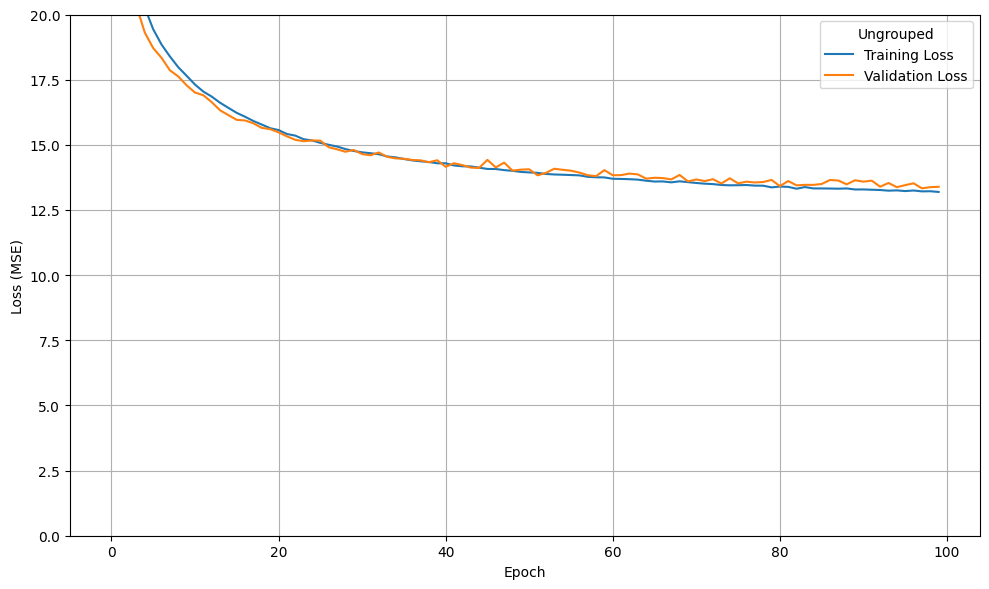

In [5]:
import pickle
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

# Path to the history file
history_path = "/scratch/midway3/nkoebelin/mux_models_new/training_history/history_rand_02_00.pkl"

# Load the training history
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
#plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(title="Ungrouped")
plt.grid(True)
plt.ylim(0,20)
plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_loss.png", dpi=300)

In [21]:
import numpy as np
import os
import pickle
from tqdm import tqdm
import re

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
output_path = os.path.join(data_dir, 'selected_patterns_results.pkl')

# --- Area test ranges ---
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (1e4, 1e5, 'area_1e4_1e5'),
    (10, 1e5, 'area_10_1e5')
]

# --- Patterns to include ---
best_random_patterns = [
    "rand_02_82",
    "rand_03_47",
    "rand_04_91",
    "rand_05_76",
    "rand_06_28",
    "rand_07_69",
    "rand_08_64",
    "rand_09_34",
    "rand_10_94"
]

best_deterministic_patterns = [
    "det_2_1_3_020",
    "det_3_1_2_020",
    "det_4_1_3_072",
    "det_5_1_2_122"
]

selected_patterns = best_random_patterns + best_deterministic_patterns

# --- Percentile function ---
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# --- Load mux pattern info ---
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# --- Collect results ---
combined_results = {}

for pattern_name in selected_patterns:
    fname = f"saved_data_{pattern_name}.npz"
    file_path = os.path.join(data_dir, fname)

    if not os.path.exists(file_path):
        print(f"❌ Missing file: {fname}")
        continue

    if pattern_name in muxing_patterns:
        n_groups = muxing_patterns[pattern_name].shape[0]
    else:
        print(f"⚠️ Warning: {pattern_name} not found in muxing_patterns.")
        n_groups = None

    with np.load(file_path) as data:
        area_test     = data['area_test']
        abs_errors    = data['abs_errors']
        radial_errors = data['radial_errors']
        pos_test      = data['pos_test']
        pos_pred      = data['pos_pred']

    model_results = {}
    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"⚠️ No events in area range {area_min}-{area_max} for model {pattern_name}")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area   = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)
        result = {
            'mux_name': pattern_name,
            'n_groups': n_groups,
            'area_range': label,
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        model_results[label] = result

    combined_results[pattern_name] = model_results

# --- Save results to file ---
with open(output_path, 'wb') as f:
    pickle.dump(combined_results, f)

print(f"\n✅ Selected pattern results saved to: {output_path}")



✅ Selected pattern results saved to: /scratch/midway3/nkoebelin/mux_data_new/selected_patterns_results.pkl


In [3]:
import pickle

with open("/scratch/midway3/nkoebelin/mux_data_new/combined_results_ungrouped.pkl", "rb") as f:
    combined_results_ungrouped = pickle.load(f)

with open("/scratch/midway3/nkoebelin/mux_data_new/selected_patterns_results.pkl", "rb") as f:
    combined_results_scat = pickle.load(f)


In [12]:
import numpy as np
import os
import pickle
from tqdm import tqdm

# Define directory and load patterns
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# Define the area test ranges and output filenames
area_ranges = [
    (200, 2000, 'results_area_200_2000.pkl'),
    (10, 50, 'results_area_10_50.pkl'),
    (10, 1e5, 'results_area_10_1e5.pkl'),
    (1e4, 1e5, 'results_area_1e4_1e5.pkl')
]

# Function to compute specified percentiles (90th, 95th, 99th)
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

for area_min, area_max, out_filename in area_ranges:
    results = []

    for fname in tqdm(os.listdir(data_dir), desc=f"Processing for area {area_min}-{area_max}"):
        if not fname.startswith("saved_data_") or not fname.endswith(".npz"):
            continue

        mux_name = fname.replace("saved_data_", "").replace(".npz", "")
        if mux_name not in muxing_patterns:
            print(f"Skipping {mux_name}: no mux pattern found.")
            continue

        try:
            with np.load(os.path.join(data_dir, fname)) as data:
                area_test = data['area_test']
                abs_errors = data['abs_errors']
                #radial_errors = data['radial_errors']
                #pos_test = data['pos_test']
                #pos_pred = data['pos_pred']
                
                mask = (area_test >= area_min) & (area_test <= area_max)

                if not np.any(mask):
                    continue

                # Compute the percentiles for the filtered abs_errors
                filtered_errors = abs_errors[mask]
                percentiles = compute_percentiles(filtered_errors)

                mean_error = filtered_errors.mean()
                median_error = np.median(filtered_errors)
                std_error = filtered_errors.std()
                n_groups = muxing_patterns[mux_name].shape[0]

                results.append({
                    'mux_name': mux_name,
                    'n_groups': n_groups,
                    'mean_error': mean_error,
                    'median_error': median_error,
                    'std_error': std_error,
                    #'radial_errors': radial_errors,
                    #'pos_test': pos_test,
                    #'pos_pred': pos_pred,
                    **percentiles  # Add the computed percentiles to the result
                })

        except Exception as e:
            print(f"Error processing {fname}: {e}")

    # Save results to pickle file
    with open(out_filename, 'wb') as f:
        pickle.dump(results, f)

    print(f"Saved {len(results)} results to {out_filename}")


Processing for area 200-2000:   7%|▋         | 107/1503 [00:09<01:49, 12.70it/s]

Skipping ungrouped_8: no mux pattern found.


Processing for area 200-2000:   8%|▊         | 118/1503 [00:10<01:50, 12.56it/s]

Skipping ungrouped_6: no mux pattern found.


Processing for area 200-2000:  12%|█▏        | 186/1503 [00:15<01:41, 12.94it/s]

Skipping ungrouped_4: no mux pattern found.


Processing for area 200-2000:  23%|██▎       | 345/1503 [00:29<01:29, 12.88it/s]

Skipping ungrouped_analysis: no mux pattern found.


Processing for area 200-2000:  42%|████▏     | 625/1503 [00:54<01:07, 13.06it/s]

Skipping ungrouped_10: no mux pattern found.


Processing for area 200-2000:  58%|█████▊    | 872/1503 [01:16<00:48, 12.94it/s]

Skipping adj_2_analysis: no mux pattern found.


Processing for area 200-2000:  65%|██████▍   | 975/1503 [01:25<00:39, 13.51it/s]

Skipping ungrouped_1: no mux pattern found.


Processing for area 200-2000:  71%|███████▏  | 1071/1503 [01:43<00:34, 12.63it/s]

Skipping adj_7_small: no mux pattern found.


Processing for area 200-2000:  72%|███████▏  | 1080/1503 [01:43<00:31, 13.55it/s]

Skipping adj_3_retrain: no mux pattern found.


Processing for area 200-2000:  72%|███████▏  | 1087/1503 [01:44<00:29, 14.23it/s]

Skipping ungrouped_7: no mux pattern found.


Processing for area 200-2000:  77%|███████▋  | 1157/1503 [01:50<00:26, 12.85it/s]

Skipping ungrouped_5: no mux pattern found.


Processing for area 200-2000:  80%|████████  | 1207/1503 [01:54<00:24, 12.27it/s]

Skipping ungrouped_9: no mux pattern found.


Processing for area 200-2000:  81%|████████▏ | 1224/1503 [01:56<00:21, 12.89it/s]

Skipping ungrouped_3: no mux pattern found.


Processing for area 200-2000:  97%|█████████▋| 1453/1503 [02:16<00:03, 13.14it/s]

Skipping ungrouped_2: no mux pattern found.


Processing for area 200-2000: 100%|██████████| 1503/1503 [02:20<00:00, 10.68it/s]


Saved 1485 results to results_area_200_2000.pkl


Processing for area 10-50:   7%|▋         | 111/1503 [00:03<00:38, 35.86it/s]

Skipping ungrouped_8: no mux pattern found.


Processing for area 10-50:   8%|▊         | 117/1503 [00:04<00:34, 39.85it/s]

Skipping ungrouped_6: no mux pattern found.


Processing for area 10-50:  13%|█▎        | 190/1503 [00:05<00:28, 46.11it/s]

Skipping ungrouped_4: no mux pattern found.


Processing for area 10-50:  23%|██▎       | 350/1503 [00:09<00:27, 41.47it/s]

Skipping ungrouped_analysis: no mux pattern found.


Processing for area 10-50:  42%|████▏     | 627/1503 [00:16<00:33, 26.39it/s]

Skipping ungrouped_10: no mux pattern found.


Processing for area 10-50:  58%|█████▊    | 877/1503 [00:24<00:13, 46.09it/s]

Skipping adj_2_analysis: no mux pattern found.


Processing for area 10-50:  65%|██████▌   | 978/1503 [00:26<00:11, 46.82it/s]

Skipping ungrouped_1: no mux pattern found.


Processing for area 10-50:  71%|███████▏  | 1073/1503 [00:29<00:15, 27.30it/s]

Skipping adj_7_small: no mux pattern found.


Processing for area 10-50:  72%|███████▏  | 1080/1503 [00:29<00:13, 30.30it/s]

Skipping adj_3_retrain: no mux pattern found.


Processing for area 10-50:  72%|███████▏  | 1088/1503 [00:30<00:13, 29.90it/s]

Skipping ungrouped_7: no mux pattern found.


Processing for area 10-50:  77%|███████▋  | 1162/1503 [00:31<00:07, 45.67it/s]

Skipping ungrouped_5: no mux pattern found.


Processing for area 10-50:  81%|████████  | 1213/1503 [00:33<00:06, 45.56it/s]

Skipping ungrouped_9: no mux pattern found.


Processing for area 10-50:  82%|████████▏ | 1229/1503 [00:33<00:05, 47.07it/s]

Skipping ungrouped_3: no mux pattern found.


Processing for area 10-50:  97%|█████████▋| 1460/1503 [00:38<00:00, 45.06it/s]

Skipping ungrouped_2: no mux pattern found.


Processing for area 10-50: 100%|██████████| 1503/1503 [00:39<00:00, 37.69it/s]


Saved 1485 results to results_area_10_50.pkl


Processing for area 10-100000.0:   7%|▋         | 109/1503 [00:04<01:00, 23.02it/s]

Skipping ungrouped_8: no mux pattern found.


Processing for area 10-100000.0:   8%|▊         | 119/1503 [00:05<00:58, 23.81it/s]

Skipping ungrouped_6: no mux pattern found.


Processing for area 10-100000.0:  12%|█▏        | 187/1503 [00:08<00:52, 25.21it/s]

Skipping ungrouped_4: no mux pattern found.


Processing for area 10-100000.0:  23%|██▎       | 346/1503 [00:16<00:48, 23.98it/s]

Skipping ungrouped_analysis: no mux pattern found.


Processing for area 10-100000.0:  42%|████▏     | 624/1503 [00:29<00:45, 19.43it/s]

Skipping ungrouped_10: no mux pattern found.


Processing for area 10-100000.0:  58%|█████▊    | 871/1503 [00:41<00:44, 14.06it/s]

Skipping adj_2_analysis: no mux pattern found.


Processing for area 10-100000.0:  65%|██████▌   | 977/1503 [00:46<00:21, 24.21it/s]

Skipping ungrouped_1: no mux pattern found.


Processing for area 10-100000.0:  71%|███████▏  | 1071/1503 [00:50<00:16, 25.68it/s]

Skipping adj_7_small: no mux pattern found.


Processing for area 10-100000.0:  72%|███████▏  | 1081/1503 [00:51<00:15, 26.39it/s]

Skipping adj_3_retrain: no mux pattern found.


Processing for area 10-100000.0:  73%|███████▎  | 1090/1503 [00:51<00:16, 24.62it/s]

Skipping ungrouped_7: no mux pattern found.


Processing for area 10-100000.0:  77%|███████▋  | 1158/1503 [00:54<00:13, 25.33it/s]

Skipping ungrouped_5: no mux pattern found.


Processing for area 10-100000.0:  80%|████████  | 1207/1503 [00:56<00:12, 24.18it/s]

Skipping ungrouped_9: no mux pattern found.


Processing for area 10-100000.0:  82%|████████▏ | 1226/1503 [00:57<00:11, 24.25it/s]

Skipping ungrouped_3: no mux pattern found.


Processing for area 10-100000.0:  97%|█████████▋| 1455/1503 [01:07<00:01, 25.33it/s]

Skipping ungrouped_2: no mux pattern found.


Processing for area 10-100000.0: 100%|██████████| 1503/1503 [01:09<00:00, 21.65it/s]


Saved 1485 results to results_area_10_1e5.pkl


Processing for area 10000.0-100000.0:   7%|▋         | 112/1503 [00:04<00:36, 38.21it/s]

Skipping ungrouped_8: no mux pattern found.


Processing for area 10000.0-100000.0:   8%|▊         | 117/1503 [00:04<00:33, 40.83it/s]

Skipping ungrouped_6: no mux pattern found.


Processing for area 10000.0-100000.0:  13%|█▎        | 192/1503 [00:06<00:32, 40.09it/s]

Skipping ungrouped_4: no mux pattern found.


Processing for area 10000.0-100000.0:  23%|██▎       | 351/1503 [00:10<00:29, 39.58it/s]

Skipping ungrouped_analysis: no mux pattern found.


Processing for area 10000.0-100000.0:  42%|████▏     | 630/1503 [00:17<00:21, 40.14it/s]

Skipping ungrouped_10: no mux pattern found.


Processing for area 10000.0-100000.0:  58%|█████▊    | 877/1503 [00:24<00:15, 40.16it/s]

Skipping adj_2_analysis: no mux pattern found.


Processing for area 10000.0-100000.0:  65%|██████▌   | 981/1503 [00:27<00:12, 40.30it/s]

Skipping ungrouped_1: no mux pattern found.


Processing for area 10000.0-100000.0:  71%|███████▏  | 1072/1503 [00:29<00:10, 41.73it/s]

Skipping adj_7_small: no mux pattern found.


Processing for area 10000.0-100000.0:  72%|███████▏  | 1082/1503 [00:29<00:09, 42.39it/s]

Skipping adj_3_retrain: no mux pattern found.
Skipping ungrouped_7: no mux pattern found.


Processing for area 10000.0-100000.0:  77%|███████▋  | 1161/1503 [00:31<00:08, 40.68it/s]

Skipping ungrouped_5: no mux pattern found.


Processing for area 10000.0-100000.0:  80%|████████  | 1208/1503 [00:32<00:07, 40.83it/s]

Skipping ungrouped_9: no mux pattern found.


Processing for area 10000.0-100000.0:  82%|████████▏ | 1228/1503 [00:33<00:06, 40.72it/s]

Skipping ungrouped_3: no mux pattern found.


Processing for area 10000.0-100000.0:  97%|█████████▋| 1460/1503 [00:39<00:00, 43.13it/s]

Skipping ungrouped_2: no mux pattern found.


Processing for area 10000.0-100000.0: 100%|██████████| 1503/1503 [00:40<00:00, 37.05it/s]


Saved 1485 results to results_area_1e4_1e5.pkl


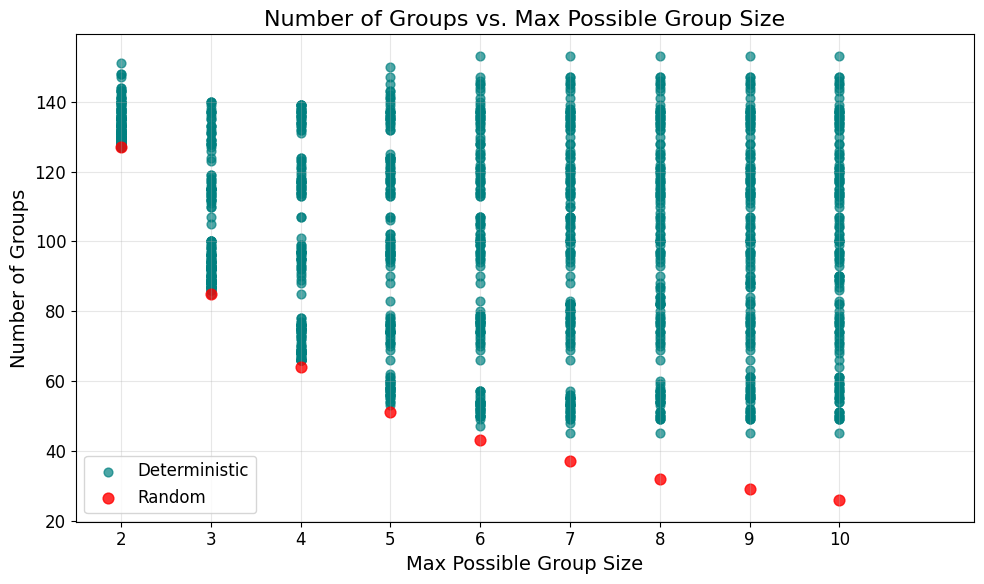

In [8]:
import matplotlib.pyplot as plt

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# Prepare data for mux_patterns_new (teal points)
x_new = []
y_new = []
labels_new = []

for key, value in patterns.items():
    if key.startswith("det"):
        group_size = int(key.split('_')[1])
        x_new.append(group_size)
        y_new.append(value.shape[0])
        labels_new.append(key)

# Prepare data for mux_patterns entries ending in "_00" (red points)
x_det = []
y_det = []
labels_det = []

for key, value in patterns.items():
    if key.endswith("_00"):
        group_size = int(key.split('_')[1])
        x_det.append(group_size)
        y_det.append(value.shape[0])
        labels_det.append(key)

# Plotting
plt.figure(figsize=(10, 6))

# Plot mux_patterns_new (teal)
plt.scatter(x_new, y_new, s=40, color='teal', alpha=0.7, label='Deterministic')
#for i in range(len(x_new)):
 #   plt.text(x_new[i] + 0.05, y_new[i], labels_new[i], fontsize=8, ha='left', va='center', color='k')

# Plot mux_patterns (red, filtered)
plt.scatter(x_det, y_det, s=60, color='red', alpha=0.8, label='Random')
#for i in range(len(x_det)):
 #   plt.text(x_det[i] + 0.05, y_det[i], labels_det[i], fontsize=8, ha='left', va='center', color='red')

plt.xlabel("Max Possible Group Size", fontsize=14)
plt.ylabel("Number of Groups", fontsize=14)
plt.title("Number of Groups vs. Max Possible Group Size", fontsize=16)
plt.grid(alpha=0.3)
plt.xlim(1.5, 11.5)
plt.xticks(sorted(set(x_new + x_det)))
plt.legend(loc='lower left')
plt.tight_layout()
#plt.show()
#plt.savefig("max_group_size_vs_number_of_groups.png", dpi=300)

In [19]:
# --- Build lookup for best deterministic patterns per max group size ---
group_counts = {name: muxing_patterns[name].shape[0] for name in deterministic_names}

# Find best deterministic pattern(s) per max group size
best_deterministic = {}
for name in deterministic_names:
    max_size = get_max_group_size(name)
    if max_size is None:
        continue
    n_groups = group_counts[name]
    if max_size not in best_deterministic:
        best_deterministic[max_size] = [(name, n_groups)]
    else:
        current_min = best_deterministic[max_size][0][1]
        if n_groups < current_min:
            best_deterministic[max_size] = [(name, n_groups)]
        elif n_groups == current_min:
            best_deterministic[max_size].append((name, n_groups))

# Flatten list of best pattern names
best_det_names = [name for entries in best_deterministic.values() for name, _ in entries]
det_filtered = [r for r in results if r['mux_name'] in best_det_names]


In [9]:
import numpy as np

# --- Load patterns ---
patterns_all = np.load("mux_patterns_all_new.npz", allow_pickle=True)

# --- Categorize patterns ---
random_names = sorted([k for k in patterns_all if k.startswith("rand_") and k.endswith("00")])
deterministic_names = sorted([k for k in patterns_all if k.startswith("det_")])

# --- Compute number of groups ---
group_counts = {name: patterns_all[name].shape[0] for name in patterns_all}

# --- Extract max group size from deterministic pattern name ---
def get_max_group_size(name):
    try:
        parts = name.split("_")
        return int(parts[1])  # e.g. det_2_3_3_000 → 2
    except Exception:
        return None

# --- Organize deterministic by max group size ---
det_by_max_size = {}
for name in deterministic_names:
    max_size = get_max_group_size(name)
    if max_size is None:
        continue
    if max_size not in det_by_max_size:
        det_by_max_size[max_size] = []
    det_by_max_size[max_size].append(name)

# --- Identify best deterministic patterns for each max group size ---
best_deterministic = {}
for max_size, names in det_by_max_size.items():
    min_groups = float("inf")
    best_names = []
    for name in names:
        n_groups = group_counts[name]
        if n_groups < min_groups:
            best_names = [name]
            min_groups = n_groups
        elif n_groups == min_groups:
            best_names.append(name)
    best_deterministic[max_size] = best_names

# --- Print random pattern results ---
print("=== Random Pattern Group Counts (ending in '00') ===")
for name in random_names:
    print(f"{name}: {group_counts[name]} groups")

# --- Print best deterministic patterns per max group size ---
print("\n=== Best Deterministic Patterns by Max Group Size ===")
for max_size in sorted(best_deterministic):
    print(f"Max group size {max_size}:")
    for name in best_deterministic[max_size]:
        print(f"  {name}: {group_counts[name]} groups")


=== Random Pattern Group Counts (ending in '00') ===
rand_02_00: 127 groups
rand_03_00: 85 groups
rand_04_00: 64 groups
rand_05_00: 51 groups
rand_06_00: 43 groups
rand_07_00: 37 groups
rand_08_00: 32 groups
rand_09_00: 29 groups
rand_10_00: 26 groups

=== Best Deterministic Patterns by Max Group Size ===
Max group size 2:
  det_2_1_1_122: 127 groups
  det_2_1_2_000: 127 groups
  det_2_1_2_163: 127 groups
  det_2_1_2_203: 127 groups
  det_2_1_3_020: 127 groups
  det_2_1_3_072: 127 groups
  det_2_1_3_240: 127 groups
  det_2_3_2_020: 127 groups
Max group size 3:
  det_3_1_2_020: 85 groups
Max group size 4:
  det_4_1_2_225: 66 groups
  det_4_1_2_240: 66 groups
  det_4_1_3_000: 66 groups
  det_4_1_3_020: 66 groups
  det_4_1_3_072: 66 groups
  det_4_1_3_098: 66 groups
  det_4_1_3_203: 66 groups
  det_4_1_3_240: 66 groups
Max group size 5:
  det_5_1_2_122: 53 groups
Max group size 6:
  det_6_1_1_000: 47 groups
Max group size 7:
  det_7_1_1_000: 45 groups
Max group size 8:
  det_8_1_1_000: 45

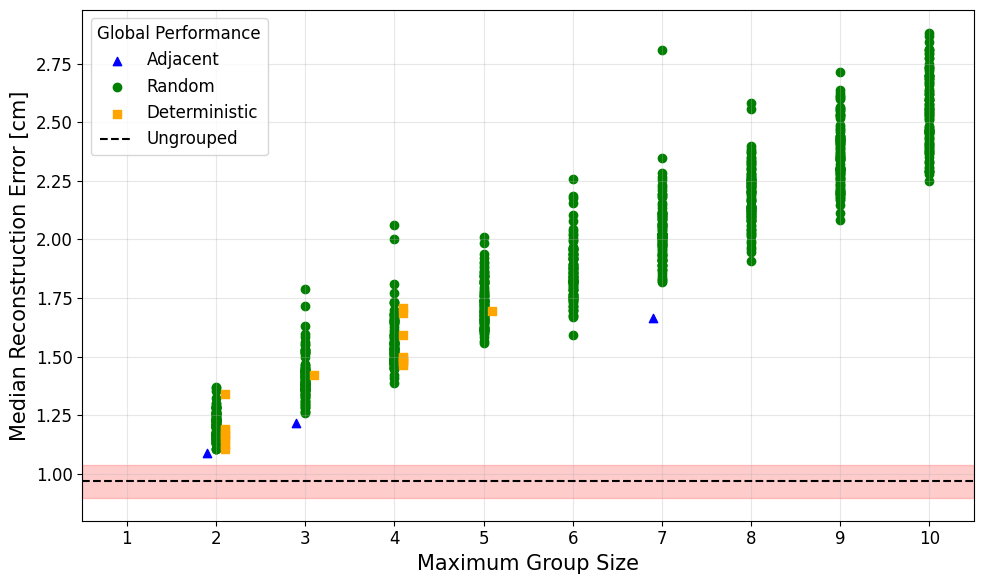

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Load results and pattern metadata ---
with open("results_area_10_1e5.pkl", "rb") as f:
#with open("results_area_10_50.pkl", "rb") as f:
    results = pickle.load(f)

muxing_patterns = np.load("mux_patterns_all_new.npz", allow_pickle=True)

# --- Extract pattern names ---
random_names = sorted([k for k in muxing_patterns if k.startswith("rand_")])
deterministic_names = sorted([k for k in muxing_patterns if k.startswith("det_")])

# --- Helper to extract max group size ---
def get_max_group_size(name):
    if name.startswith("det_") or name.startswith("rand_"):
        try:
            return int(name.split("_")[1])
        except:
            return None
    elif name.startswith("adj_") and re.match(r"adj_\d+($|_)", name):
        return int(name.split("_")[1])
    elif name == "ungrouped":
        return 1  # fallback
    else:
        return None

# --- Tag results with max group size ---
for r in results:
    r["max_group_size"] = get_max_group_size(r["mux_name"])

# --- Group by type ---
def filter_results(names):
    return [r for r in results if r["mux_name"] in names]

random_filtered = filter_results(random_names)
det_names_best = []
for name in deterministic_names:
    max_size = get_max_group_size(name)
    if max_size is None:
        continue
    det_names_best.append(name)

# --- Build lookup for best deterministic patterns per max group size ---
group_counts = {name: muxing_patterns[name].shape[0] for name in deterministic_names}

# Find best deterministic pattern(s) per max group size
best_deterministic = {}
for name in deterministic_names:
    max_size = get_max_group_size(name)
    if max_size is None:
        continue
    n_groups = group_counts[name]
    if max_size not in best_deterministic:
        best_deterministic[max_size] = [(name, n_groups)]
    else:
        current_min = best_deterministic[max_size][0][1]
        if n_groups < current_min:
            best_deterministic[max_size] = [(name, n_groups)]
        elif n_groups == current_min:
            best_deterministic[max_size].append((name, n_groups))

# Flatten list of best pattern names
# Flatten and filter by max group size 2–5
best_det_names = [name for max_size, entries in best_deterministic.items() if max_size <= 5 for name, _ in entries]
det_filtered = [r for r in results if r['mux_name'] in best_det_names]


adj_numbered = [r for r in results if re.match(r"adj_(2|3|7)($|_)", r['mux_name'])]
adj_named = [r for r in results if r['mux_name'].startswith("adj_") and not re.match(r"adj_\d+($|_)", r['mux_name'])]
ungrouped = next((r for r in results if r['mux_name'] == 'ungrouped'), None)

# --- Plotting ---
plt.figure(figsize=(10, 6))

def scatter_plot(entries, color, label, marker, x_offset=0.0):
    x = [r["max_group_size"] + x_offset for r in entries]
    y = [r["median_error"] for r in entries]
    if x and y:
        plt.scatter(x, y, color=color, label=label, alpha=1, marker=marker)
        
scatter_plot(adj_numbered, "blue", "Adjacent", "^", x_offset=-0.1)
scatter_plot(random_filtered, "green", "Random", "o", x_offset=0.00)
scatter_plot(det_filtered, "orange", "Deterministic", "s", x_offset=+0.1)

if ungrouped:
    mu = ungrouped['median_error']
    mu = 0.97
    plt.axhline(mu, linestyle="--", color="k", label="Ungrouped")
    plt.fill_between(
        x=np.linspace(0.5, 10.5, 500),
        y1=mu - 0.07,
        y2=mu + 0.07,
        color="red",
        alpha=0.1
        #label="Training Fluctuations"
    )

plt.xlabel("Group Size")
plt.ylabel("Median Reconstruction Error [cm]")
#plt.title("Median Error vs. Max Group Size (200–2000 PE)")
plt.grid(alpha=0.3)
plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)
plt.legend(title="Global Performance")
plt.tight_layout()
#plt.savefig("scattered_rec_err_vs_max_group_size_10-1e5PE.png", dpi=300)
plt.show()

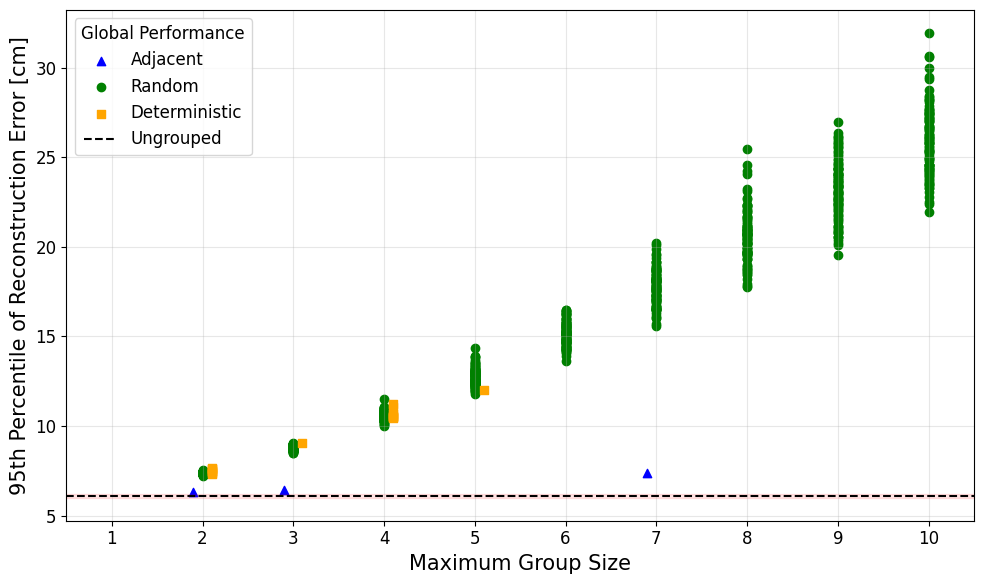

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Load results and pattern metadata ---
with open("results_area_10_1e5.pkl", "rb") as f:
    results = pickle.load(f)

muxing_patterns = np.load("mux_patterns_all_new.npz", allow_pickle=True)

# --- Extract pattern names ---
random_names = sorted([k for k in muxing_patterns if k.startswith("rand_")])
deterministic_names = sorted([k for k in muxing_patterns if k.startswith("det_")])

# --- Helper to extract max group size ---
def get_max_group_size(name):
    if name.startswith("det_") or name.startswith("rand_"):
        try:
            return int(name.split("_")[1])
        except:
            return None
    elif name.startswith("adj_") and re.match(r"adj_\d+($|_)", name):
        return int(name.split("_")[1])
    elif name == "ungrouped":
        return 1  # fallback
    else:
        return None

# --- Tag results with max group size ---
for r in results:
    r["max_group_size"] = get_max_group_size(r["mux_name"])

# --- Group by type ---
def filter_results(names):
    return [r for r in results if r["mux_name"] in names]

random_filtered = filter_results(random_names)

# Filter deterministic by best patterns per max group size
group_counts = {name: muxing_patterns[name].shape[0] for name in deterministic_names}
best_deterministic = {}
for name in deterministic_names:
    max_size = get_max_group_size(name)
    if max_size is None:
        continue
    n_groups = group_counts[name]
    if max_size not in best_deterministic or n_groups < best_deterministic[max_size][0][1]:
        best_deterministic[max_size] = [(name, n_groups)]
    elif n_groups == best_deterministic[max_size][0][1]:
        best_deterministic[max_size].append((name, n_groups))

best_det_names = [name for max_size, entries in best_deterministic.items() if max_size <= 5 for name, _ in entries]
det_filtered = [r for r in results if r['mux_name'] in best_det_names]

# Adjacent patterns
adj_numbered = [r for r in results if re.match(r"adj_(2|3|7)($|_)", r['mux_name'])]
adj_named = [r for r in results if r['mux_name'].startswith("adj_") and not re.match(r"adj_\d+($|_)", r['mux_name'])]
ungrouped = next((r for r in results if r['mux_name'] == 'ungrouped'), None)

# --- Plotting ---
plt.figure(figsize=(10, 6))

def scatter_plot(entries, color, label, marker, x_offset=0.0):
    x = [r["max_group_size"] + x_offset for r in entries]
    y = [r["95th_percentile"] for r in entries]
    if x and y:
        plt.scatter(x, y, color=color, label=label, alpha=1, marker=marker)

scatter_plot(adj_numbered, "blue", "Adjacent", "^", x_offset=-0.1)
scatter_plot(random_filtered, "green", "Random", "o", x_offset=0.00)
scatter_plot(det_filtered, "orange", "Deterministic", "s", x_offset=+0.1)

if ungrouped:
    p95 = ungrouped['95th_percentile']
    p95 = 6.11
    plt.axhline(p95, linestyle="--", color="k", label="Ungrouped")
    plt.fill_between(
        x=np.linspace(0.5, 10.5, 500),
        y1=p95 - 0.1,
        y2=p95 + 0.1,
        color="red",
        alpha=0.1
    )

plt.xlabel("Group Size")
plt.ylabel("95th Percentile of Reconstruction Error [cm]")
plt.grid(alpha=0.3)
plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)
plt.legend(title="Global Performance")
plt.tight_layout()
#plt.savefig("scattered_95percentile_vs_max_group_size_10-1e5PE.png", dpi=300)
plt.show()


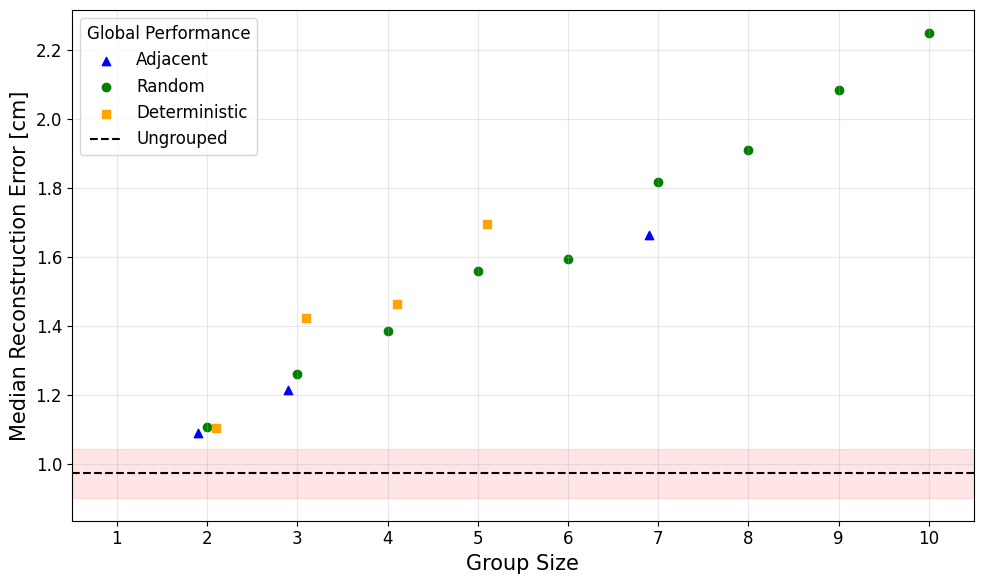

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Load results and patterns ---
with open("results_area_10_1e5.pkl", "rb") as f:
    results = pickle.load(f)

muxing_patterns = np.load("mux_patterns_all_new.npz", allow_pickle=True)

# --- Selected patterns only ---
best_random_patterns = [
    "rand_02_82", "rand_03_47", "rand_04_91", "rand_05_76", "rand_06_28",
    "rand_07_69", "rand_08_64", "rand_09_34", "rand_10_94"
]

best_deterministic_patterns = [
    "det_2_1_3_020", "det_3_1_2_020", "det_4_1_3_072", "det_5_1_2_122"
]

selected_adj = ["adj_2", "adj_3", "adj_7"]
selected_all = set(best_random_patterns + best_deterministic_patterns + selected_adj + ["ungrouped"])

# --- Helper to extract max group size ---
def get_max_group_size(name):
    if name.startswith("det_") or name.startswith("rand_"):
        try:
            return int(name.split("_")[1])
        except:
            return None
    elif name.startswith("adj_") and re.match(r"adj_\d+($|_)", name):
        return int(name.split("_")[1])
    elif name == "ungrouped":
        return 1
    return None

# --- Filter results to only selected patterns ---
filtered_results = [r for r in results if r["mux_name"] in selected_all]

# --- Tag results with max group size ---
for r in filtered_results:
    r["max_group_size"] = get_max_group_size(r["mux_name"])

# --- Categorize by type ---
adj_filtered = [r for r in filtered_results if r["mux_name"] in selected_adj]
random_filtered = [r for r in filtered_results if r["mux_name"] in best_random_patterns]
det_filtered = [r for r in filtered_results if r["mux_name"] in best_deterministic_patterns]
ungrouped = next((r for r in filtered_results if r["mux_name"] == 'ungrouped'), None)

# --- Plotting ---
plt.figure(figsize=(10, 6))

def scatter_plot(entries, color, label, marker, x_offset=0.0):
    x = [r["max_group_size"] + x_offset for r in entries]
    y = [r["median_error"] for r in entries]
    if x and y:
        plt.scatter(x, y, color=color, label=label, alpha=1, marker=marker)

scatter_plot(adj_filtered, "blue", "Adjacent", "^", x_offset=-0.1)
scatter_plot(random_filtered, "green", "Random", "o", x_offset=0.00)
scatter_plot(det_filtered, "orange", "Deterministic", "s", x_offset=+0.1)

if ungrouped:
    mu = ungrouped['median_error']
    plt.axhline(mu, linestyle="--", color="k", label="Ungrouped")
    plt.fill_between(
        x=np.linspace(0.5, 10.5, 500),
        y1=mu - 0.07,
        y2=mu + 0.07,
        color="red",
        alpha=0.1
    )

plt.xlabel("Group Size")
plt.ylabel("Median Reconstruction Error [cm]")
plt.grid(alpha=0.2)
plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)
plt.legend(title="Global Performance")
plt.tight_layout()
# plt.savefig("selected_patterns_vs_median_error.png", dpi=300)
plt.show()


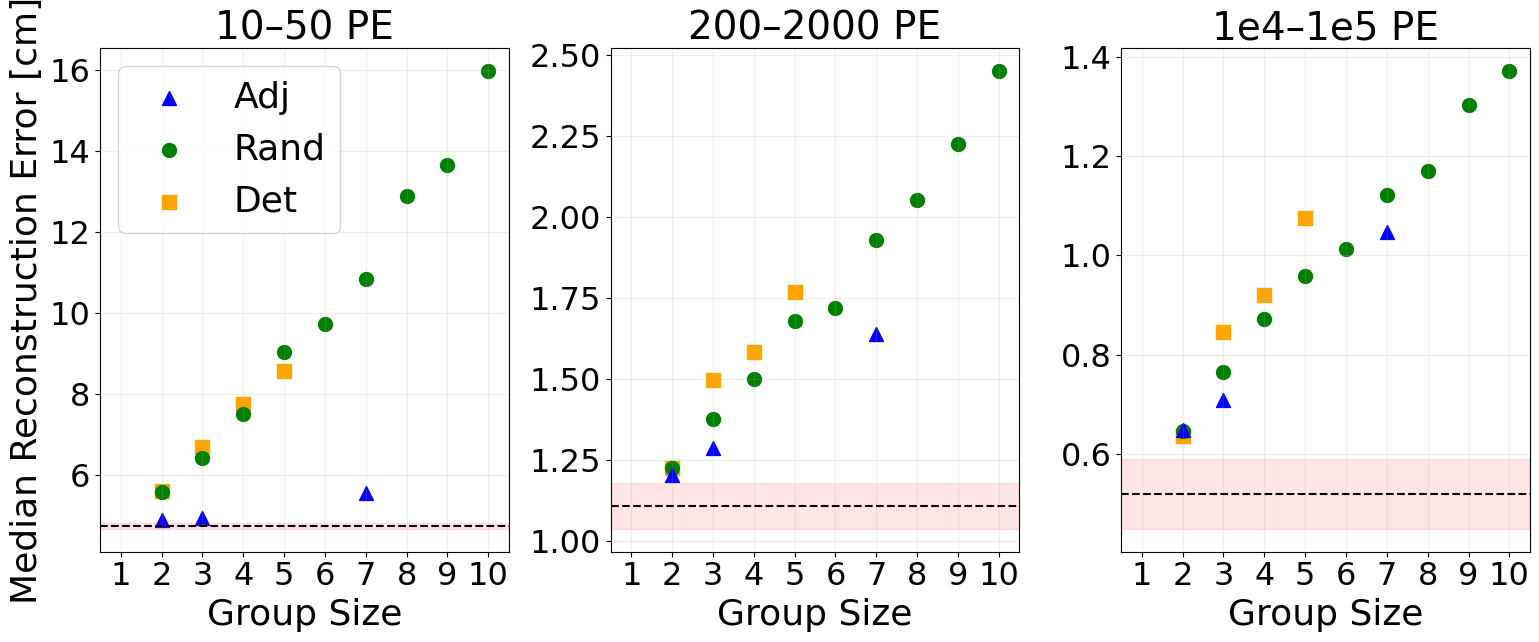

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Energy ranges and labels ---
energy_configs = [
    ("results_area_10_50.pkl", "10–50 PE"),
    ("results_area_200_2000.pkl", "200–2000 PE"),
    ("results_area_1e4_1e5.pkl", "1e4–1e5 PE")
]

# --- Selected patterns ---
best_random_patterns = [
    "rand_02_82", "rand_03_47", "rand_04_91", "rand_05_76", "rand_06_28",
    "rand_07_69", "rand_08_64", "rand_09_34", "rand_10_94"
]

best_deterministic_patterns = [
    "det_2_1_3_020", "det_3_1_2_020", "det_4_1_3_072", "det_5_1_2_122"
]

selected_adj = ["adj_2", "adj_3", "adj_7"]
selected_all = set(best_random_patterns + best_deterministic_patterns + selected_adj + ["ungrouped"])

# --- Helper to extract max group size ---
def get_max_group_size(name):
    if name.startswith("det_") or name.startswith("rand_"):
        return int(name.split("_")[1])
    elif name.startswith("adj_") and re.match(r"adj_\d+($|_)", name):
        return int(name.split("_")[1])
    elif name == "ungrouped":
        return 1
    return None

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(16, 7))#, sharey=True)

for ax, (filename, label) in zip(axes, energy_configs):
    with open(filename, "rb") as f:
        results = pickle.load(f)

    # Filter only selected patterns
    filtered_results = [r for r in results if r["mux_name"] in selected_all]

    # Tag max group size
    for r in filtered_results:
        r["max_group_size"] = get_max_group_size(r["mux_name"])

    # Categorize by type
    adj_filtered = [r for r in filtered_results if r["mux_name"] in selected_adj]
    rand_filtered = [r for r in filtered_results if r["mux_name"] in best_random_patterns]
    det_filtered  = [r for r in filtered_results if r["mux_name"] in best_deterministic_patterns]
    ungrouped     = next((r for r in filtered_results if r["mux_name"] == 'ungrouped'), None)

    def scatter_plot(entries, color, label, marker, x_offset=0.0):
        x = [r["max_group_size"] + x_offset for r in entries]
        y = [r["median_error"] for r in entries]
        if x and y:
            ax.scatter(x, y, color=color, label=label, alpha=1, marker=marker, s=100)

    # Plot points
    scatter_plot(det_filtered, "orange", "Det", "s", x_offset=+0.0)
    scatter_plot(rand_filtered, "green", "Rand", "o", x_offset=0.00)
    scatter_plot(adj_filtered, "blue", "Adj", "^", x_offset=-0.0)

    # Plot ungrouped line and capture handle
    ungrouped_handle = None
    if ungrouped:
        mu = ungrouped["median_error"]
        ungrouped_handle = ax.axhline(mu, linestyle="--", color="k", label="Ungrouped")
        ax.fill_between(np.linspace(0.5, 10.5, 500), mu - 0.07, mu + 0.07, color="red", alpha=0.1)

    # Get existing handles and labels
    handles, labels = ax.get_legend_handles_labels()
    label_order = ["Adj", "Rand", "Det"]

    # Add ungrouped manually if it’s not auto-included
    if ungrouped_handle and "Ungrouped" not in labels:
        handles.append(ungrouped_handle)
        labels.append("Ungrouped")

    # Reorder
    label_to_handle = dict(zip(labels, handles))
    ordered_handles = [label_to_handle[lbl] for lbl in label_order if lbl in label_to_handle]
    ordered_labels  = [lbl for lbl in label_order if lbl in label_to_handle]

    ax.set_title(label)
    ax.set_xlabel("Group Size")
    ax.grid(alpha=0.2)
    ax.set_xticks(range(1, 11))
    ax.set_xlim(0.5, 10.5)

axes[0].set_ylabel("Median Reconstruction Error [cm]")
#axes[0].legend(title="Global Performance", loc='upper left')
axes[0].legend(ordered_handles, ordered_labels)
plt.tight_layout()
#plt.savefig("scattered_median_vs_group_size_all_ranges.png", dpi=300)
plt.show()


In [9]:
# Load supporting files
idx_test_array = np.load("idx_test_global.npy")
lookup_dict = np.load("global_index_lookup.npy", allow_pickle=True).item()
pmt_xy_top = np.load("hex_pattern_data.npz", allow_pickle=True)["pmt_xy_top"]
mux_patterns = np.load("mux_patterns_all_new.npz", allow_pickle=True)
raw_data_path = "/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/"
rns = np.load("mux_patterns_all_new.npz", allow_pickle=True)


In [62]:
def plot_two_grouping_comparison(
    mux_pattern_file,
    hex_geometry_file,
    model_names,  # List of 2 strings like ['adj_2', 'rand_02_82']
    highlight_indices,  # List of 2 ints
    extra_highlight_groups=None,  # List of 2 lists of group indices
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import matplotlib.colors as mcolors
    import os

    assert len(model_names) == 2, "Provide exactly two model names."
    assert len(highlight_indices) == 2, "Provide one highlight index per model."

    if extra_highlight_groups is None:
        extra_highlight_groups = [[], []]
    else:
        assert len(extra_highlight_groups) == 2, "extra_highlight_groups must have two entries."

    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]

    mux_patterns = np.load(mux_pattern_file, allow_pickle=True)

    def generate_pastel_colors(n, darken_factor=0.85):
        import random
        pastel_colors = []
        for _ in range(n):
            base = [random.random() for _ in range(3)]
            pastel = [(1 + c) / 2 * darken_factor for c in base]
            pastel_colors.append(mcolors.to_hex(pastel))
        return pastel_colors

    fig, axes = plt.subplots(1, 2, figsize=(12, 9))

    for i, ax in enumerate(axes):
        mux_name = model_names[i]
        highlight_idx = highlight_indices[i]
        group_indices_to_outline = extra_highlight_groups[i]

        mux = mux_patterns[mux_name]
        groups = [[int(p) for p in g if p != -1] for g in mux]
        pastel_colors = generate_pastel_colors(len(groups), darken_factor=1)

        for j, group in enumerate(groups):
            group_arr = np.array(group)
            x = pmt_x_top[group_arr]
            y = pmt_y_top[group_arr]

            if j == highlight_idx:
                ax.scatter(x, y, c='red', edgecolors='black', s=370, linewidths=2.5, marker='o')
            else:
                ax.scatter(x, y, c=pastel_colors[j], edgecolors='none', s=400, marker='o')

        for j in group_indices_to_outline:
            if j < len(groups):
                group_arr = np.array(groups[j])
                x = pmt_x_top[group_arr]
                y = pmt_y_top[group_arr]
                ax.scatter(x, y, facecolors='red', edgecolors='k', s=400, linewidths=2.5, marker='o')

        # Title: pretty format
        title = mux_name.replace("adj_", "Adjacent ").replace("rand_", "Random ").split("_")[0:2]
        if mux_name.startswith("rand_"):
            title = f"Random {int(mux_name.split('_')[1])}"
        elif mux_name.startswith("det_"):
            title = f"Deterministic {int(mux_name.split('_')[1])}"
        else:
            title = mux_name.replace("adj_", "Adjacent ")

        ax.set_title(title, fontsize=28)
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])
        circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
        ax.add_patch(circle)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    if save_image:
        save_path = os.path.join(image_dir, "grouping_comparison_2x1.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()


Saved: /home/nkoebelin/Images/grouping_comparison_2x1.png


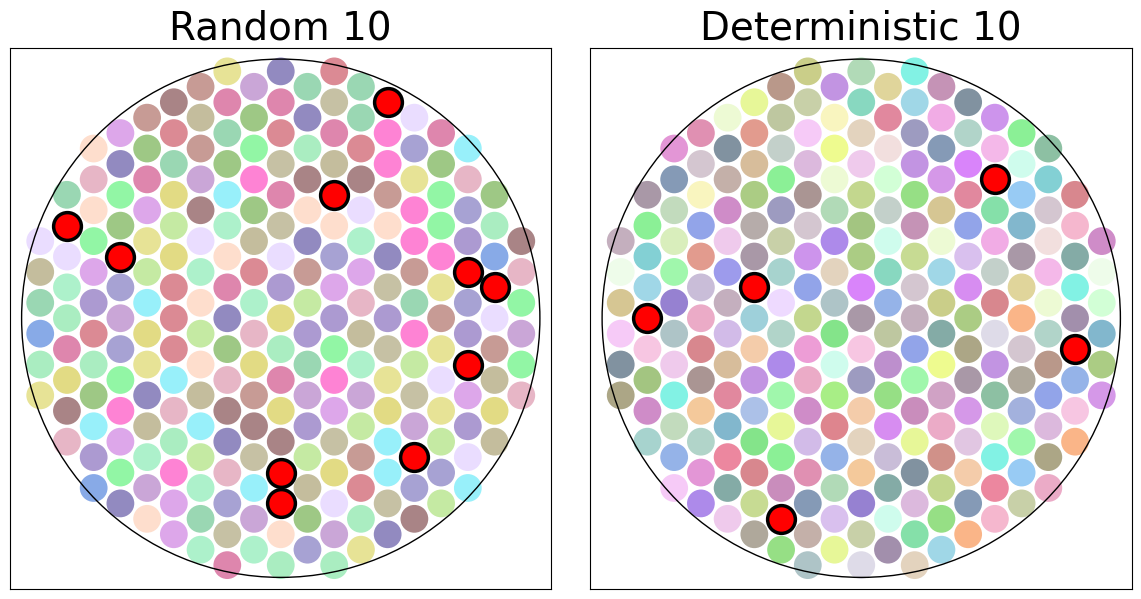

In [63]:
highlight = 15
model_names = ['rand_10_94', 'det_10_3_2_122']
highlight_indices = [59, 126]
extra_highlight_groups = [
    [15],  # groups to outline in adj_2
    [27]    # groups to outline in rand_02_82
]

plot_two_grouping_comparison(
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    model_names=model_names,
    highlight_indices=highlight_indices,
    extra_highlight_groups=extra_highlight_groups,
    save_image=True  # set False if you don't want to save
)


In [ ]:
best_random_patterns = [
    "rand_02_82",
    "rand_03_47",
    "rand_04_91",
    "rand_05_76",
    "rand_06_28",
    "rand_07_69",
    "rand_08_64",
    "rand_09_34",
    "rand_10_94"
]

best_deterministic_patterns = [
    "det_2_1_3_020",
    "det_3_1_2_020",
    "det_4_1_3_072",
    "det_5_1_2_122"
]

/scratch/local/jobs/33636597/ipykernel_1704669/4099167665.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


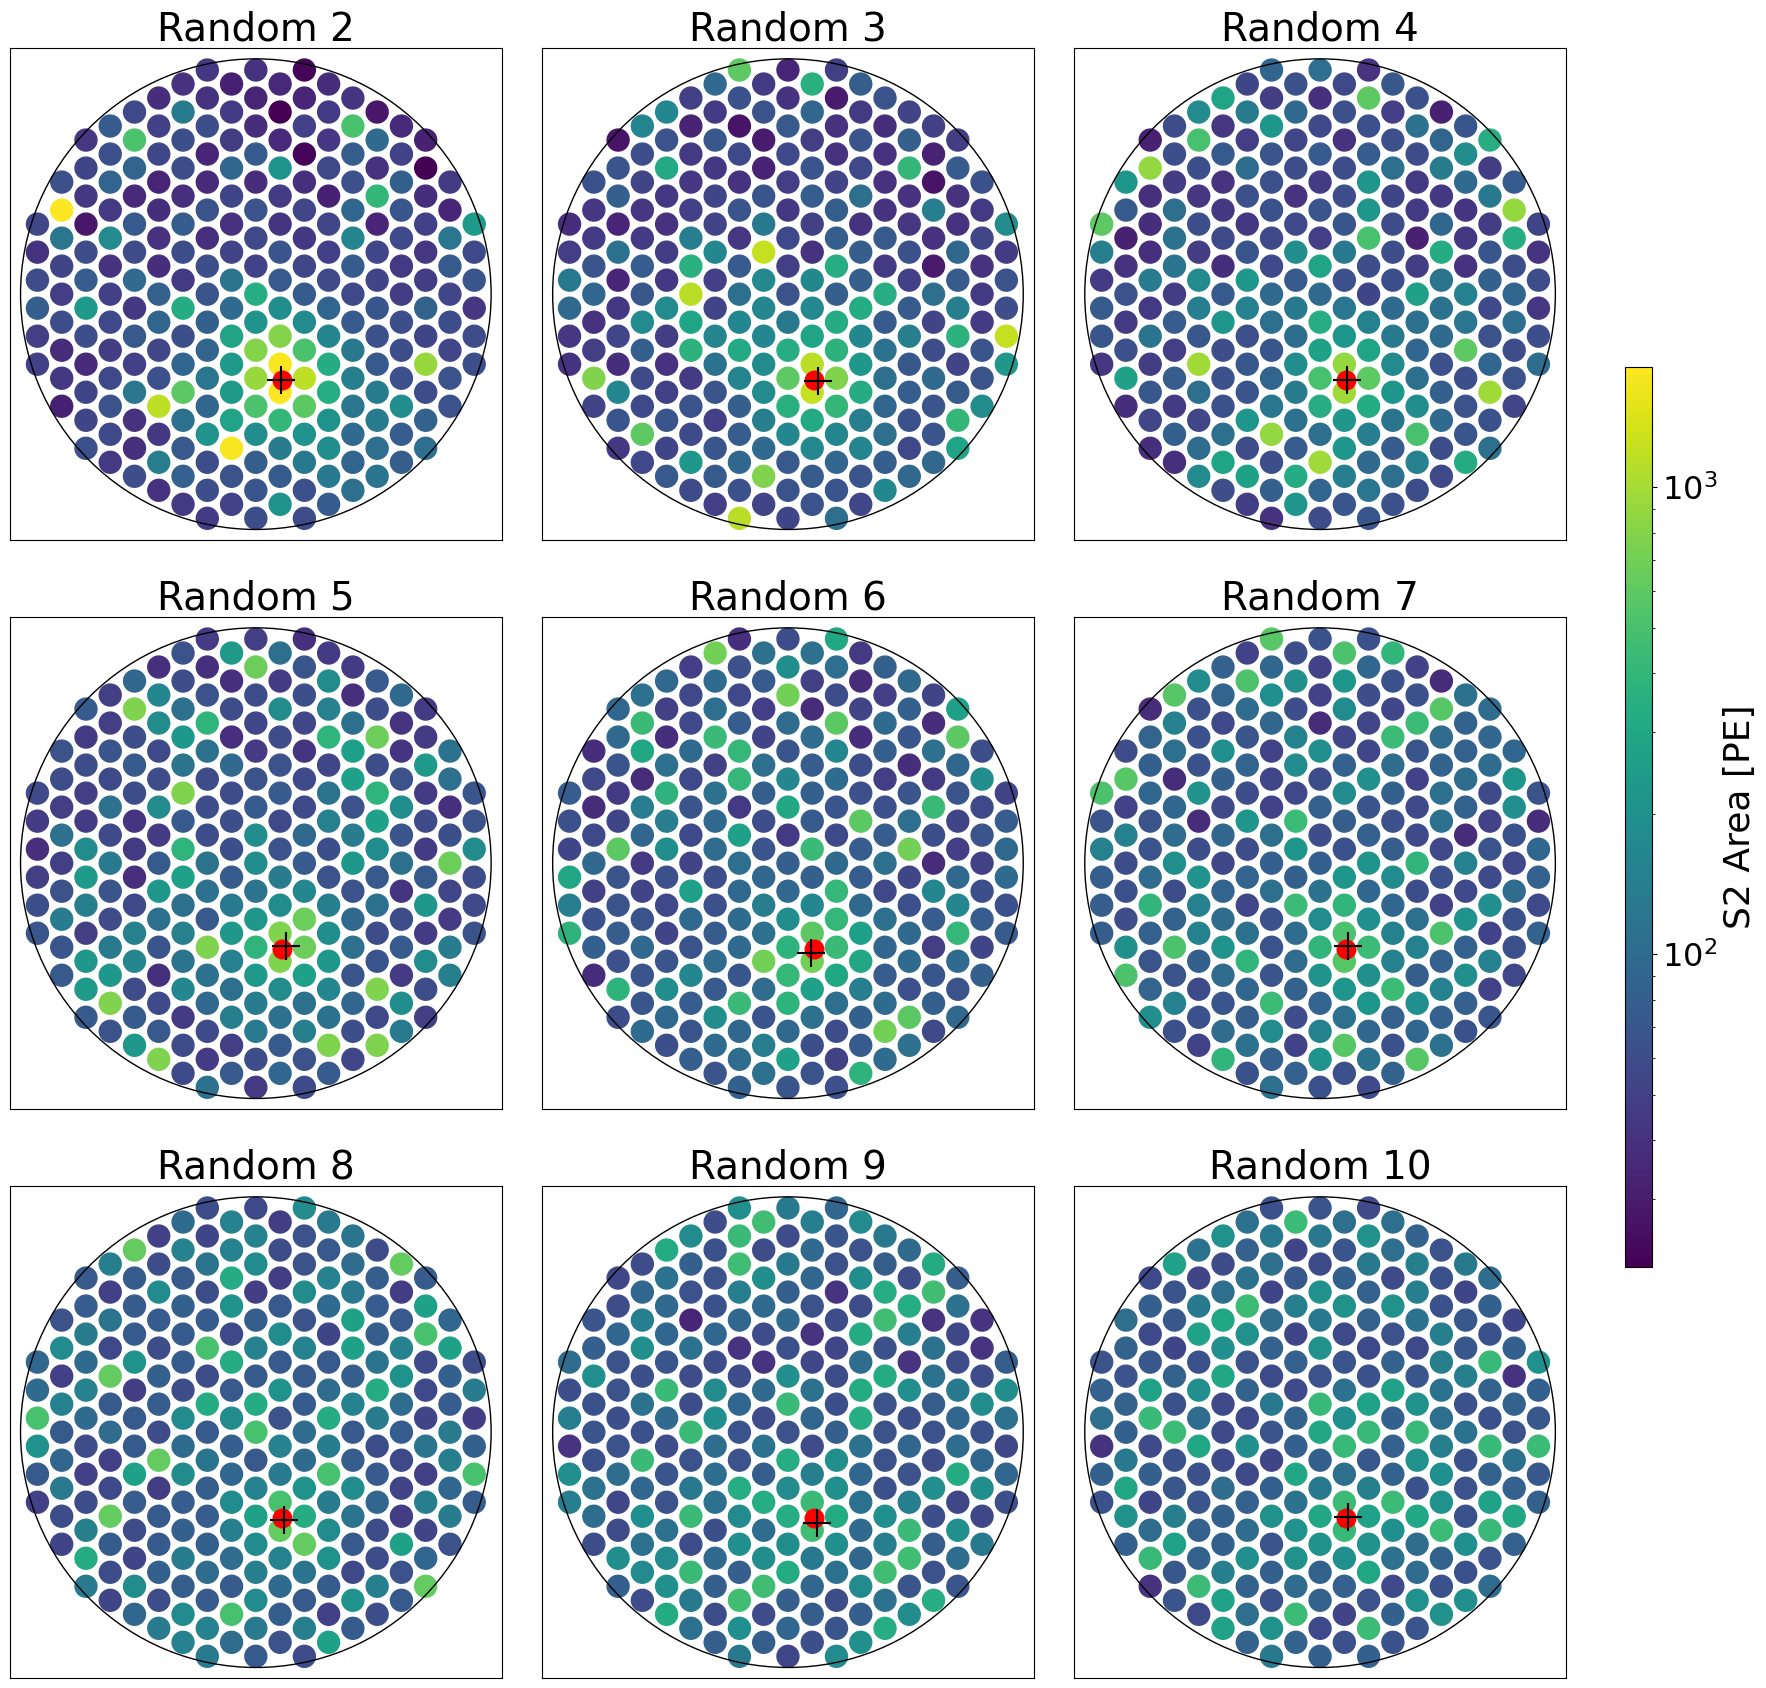

In [7]:
def plot_hitpattern_grid(
    test_idx,
    raw_data_path,
    base_npz_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    model_names,  # now passed in explicitly (9 strings)
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    # --- Font size setup ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    fig, axes = plt.subplots(3, 3, figsize=(18, 18))

    all_pmt_intensities = []  # for global color scaling

    # First pass: compute per-model group values and global color limits
    for mux_name in model_names:
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        # Handle -1 padding if present
        groups = [[int(p) for p in g if p != -1] for g in mux]

        group_values = np.zeros(len(groups))
        for j, group in enumerate(groups):
            if group:
                group_values[j] = np.sum(hitpattern[group])

        pmt_intensity = np.zeros(PMTs_top)
        for j, group in enumerate(groups):
            if group:
                pmt_intensity[group] = group_values[j] / len(group)

        all_pmt_intensities.append(pmt_intensity)

    all_values = np.concatenate(all_pmt_intensities)
    vmin = np.min(all_values[all_values > 0])
    vmax = np.max(all_values)

    # Second pass: plot grid
    for i, ax in enumerate(axes.flatten()):
        mux_name = model_names[i]
        npz_path = os.path.join(base_npz_path, f"saved_data_{mux_name}.npz")
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [[int(p) for p in g if p != -1] for g in mux]

        npz = np.load(npz_path)
        pred = npz["pos_pred"][test_idx]
        abs_err = npz["abs_errors"][test_idx]

        pmt_intensity = all_pmt_intensities[i]
        sc = ax.scatter(pmt_x_top, pmt_y_top, c=pmt_intensity, cmap='viridis', marker='o', s=250, norm=LogNorm(vmin=vmin, vmax=vmax))
        ax.scatter(interface_x, interface_y, c='red', marker='o', s=180, label='MC Position')
        ax.scatter(pred[0], pred[1], c='k', marker='+', s=400, label=f'Error={abs_err:.2f} cm')

        circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
        ax.add_patch(circle)

        group_size = mux_name.split("_")[1]  # e.g., "02" from "rand_02_82"
        ax.set_title(f"Random {int(group_size)}", fontsize=28)
        ax.set_aspect('equal')
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.grid(alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='S2 Area [PE]')

    plt.tight_layout(rect=[0, 0, 0.91, 0.97])

    if save_image:
        out_path = os.path.join(image_dir, f"scattered_hitpattern_grid_event{test_idx}.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved: {out_path}")

    plt.show()

scat_models = [
    'rand_02_82', 'rand_03_47', 'rand_04_91',
    'rand_05_76', 'rand_06_28', 'rand_07_69',
    'rand_08_64', 'rand_09_34', 'rand_10_94'
]




plot_hitpattern_grid(
    test_idx=4,
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    base_npz_path="/scratch/midway3/nkoebelin/mux_data_new",
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=np.load("idx_test_global_area_cut.npy"),
    lookup_dict=np.load("global_index_lookup.npy", allow_pickle=True).item(),
    model_names=scat_models,
    save_image=False
)

/scratch/local/jobs/33636597/ipykernel_1704669/4099167665.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


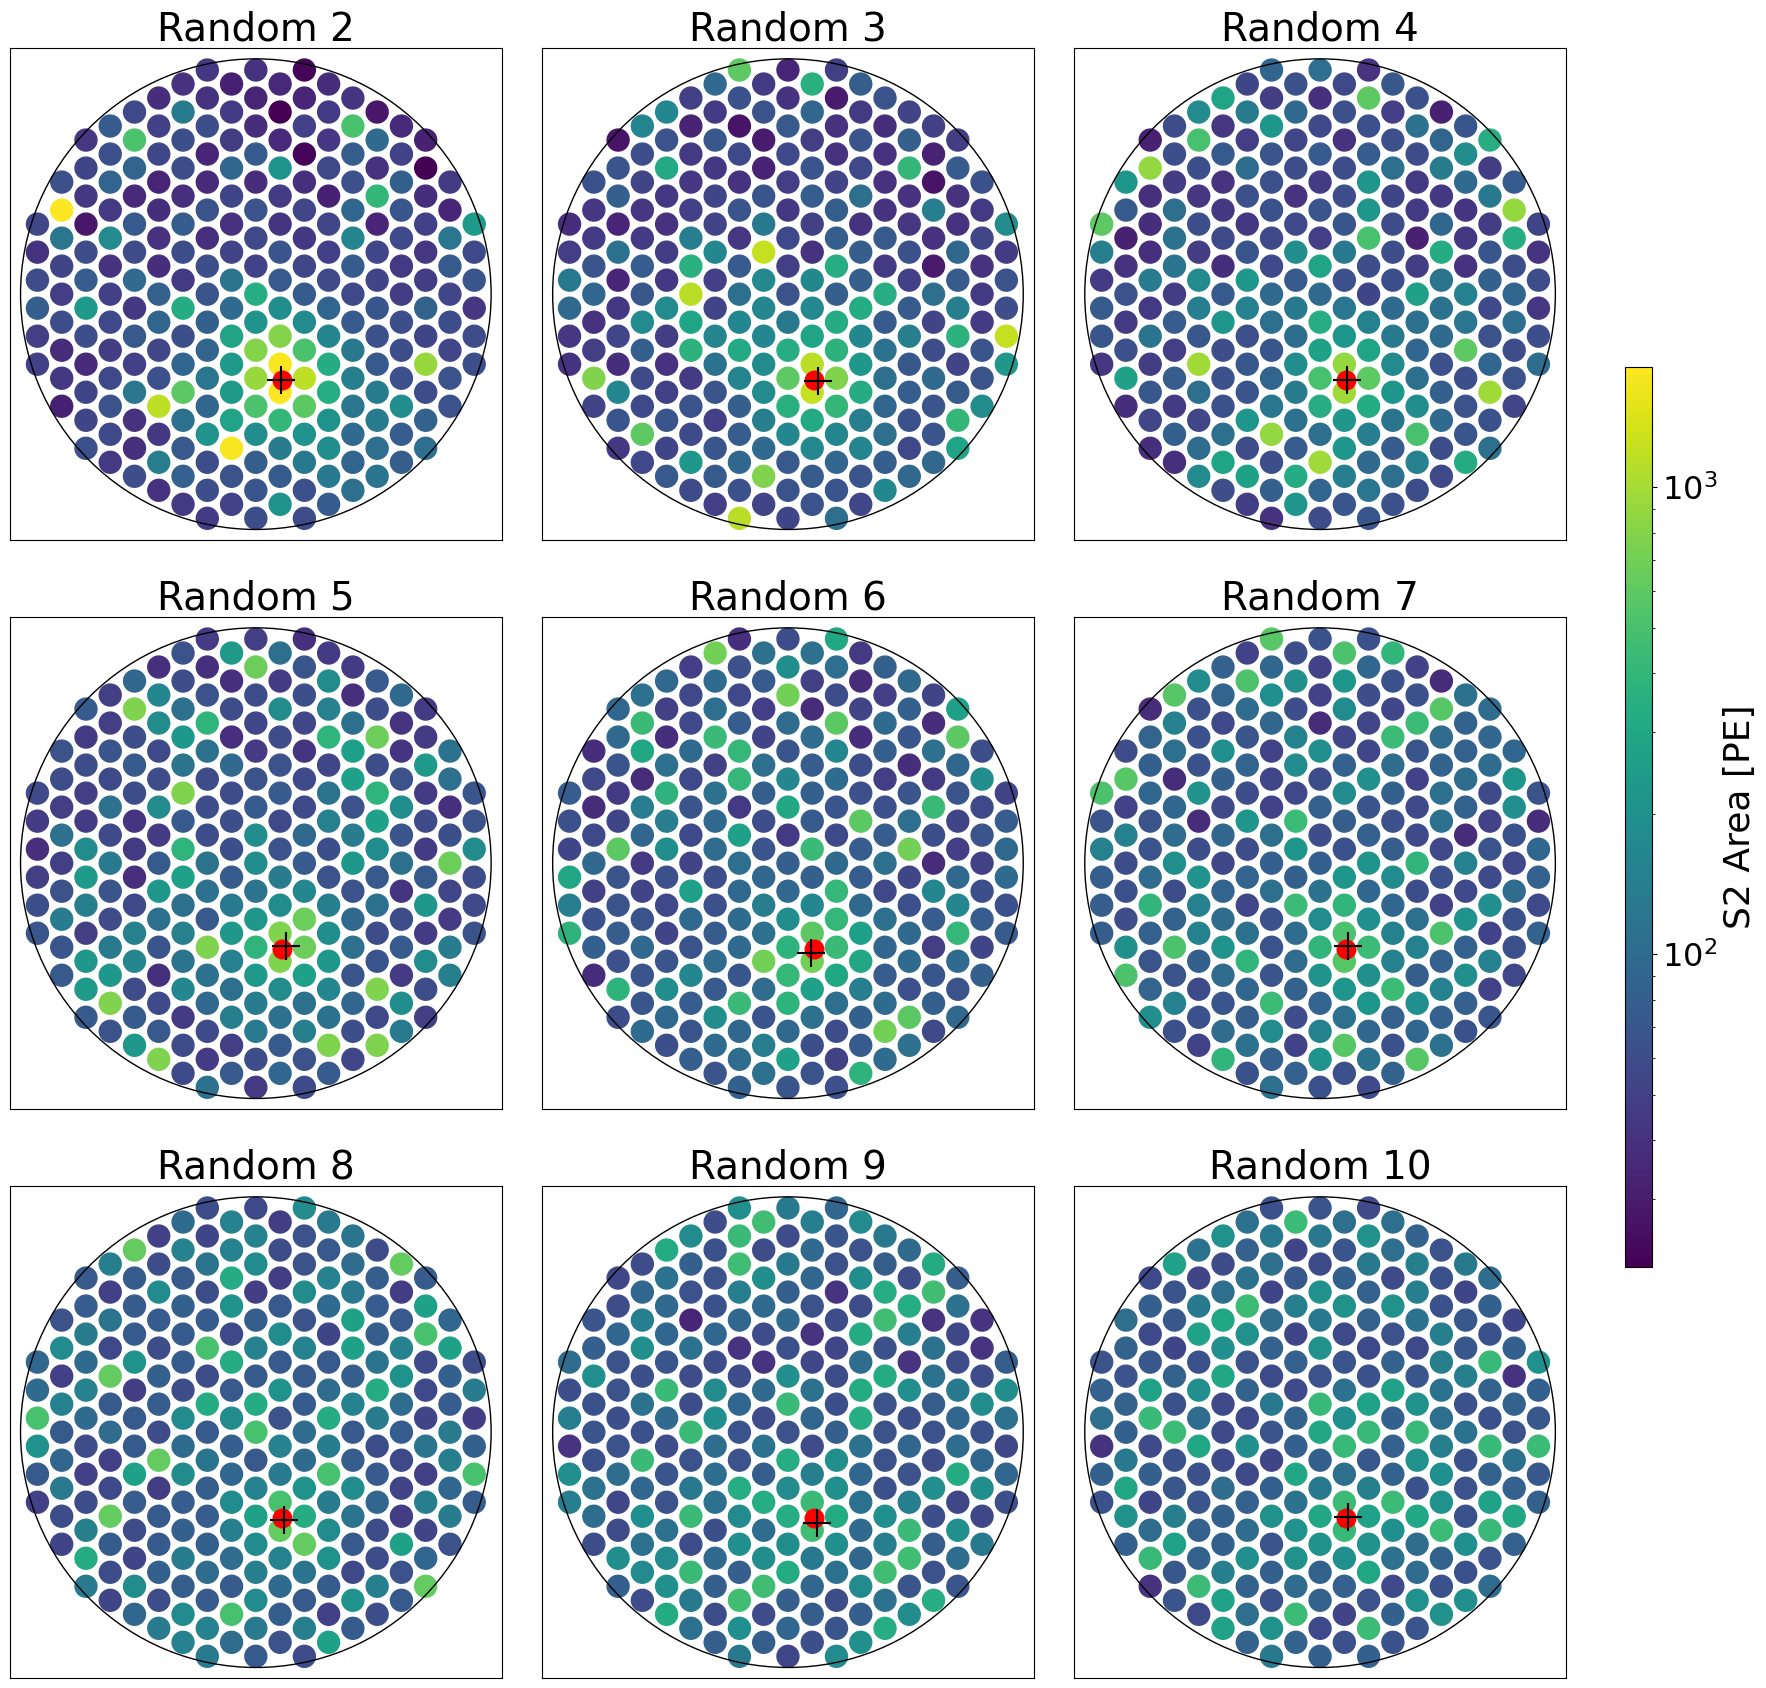

In [11]:
def plot_hitpattern_grid_random(
    test_idx,
    raw_data_path,
    base_npz_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    model_names,  # 9 entries, e.g. rand_02_82 -> rand_10_94
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    # --- Font size setup to match reference layout ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]

    fig, axes = plt.subplots(3, 3, figsize=(18, 18))

    all_pmt_intensities = []

    # --- First pass: get per-model intensities ---
    for mux_name in model_names:
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [[int(p) for p in g if p != -1] for g in mux]

        group_values = np.zeros(len(groups))
        for j, group in enumerate(groups):
            if group:
                group_values[j] = np.sum(hitpattern[group])

        pmt_intensity = np.zeros(PMTs_top)
        for j, group in enumerate(groups):
            if group:
                pmt_intensity[group] = group_values[j] / len(group)

        all_pmt_intensities.append(pmt_intensity)

    all_values = np.concatenate(all_pmt_intensities)
    vmin = np.min(all_values[all_values > 0])
    vmax = np.max(all_values)

    # --- Second pass: plot each panel ---
    for i, ax in enumerate(axes.flatten()):
        mux_name = model_names[i]
        npz_path = os.path.join(base_npz_path, f"saved_data_{mux_name}.npz")

        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [[int(p) for p in g if p != -1] for g in mux]

        npz = np.load(npz_path)
        pred = npz["pos_pred"][test_idx]
        abs_err = npz["abs_errors"][test_idx]

        pmt_intensity = all_pmt_intensities[i]
        sc = ax.scatter(pmt_x_top, pmt_y_top, c=pmt_intensity, cmap='viridis', s=250, marker='o', norm=LogNorm(vmin=vmin, vmax=vmax))
        ax.scatter(interface_x, interface_y, c='red', marker='o', s=180, label='MC Position')
        ax.scatter(pred[0], pred[1], c='k', marker='+', s=400, label=f'Error={abs_err:.2f} cm')

        ax.add_patch(Circle((0, 0), 67, color='k', fill=False, linewidth=1))

        # Custom title: "Random 2" etc.
        group_size = int(mux_name.split("_")[1])
        ax.set_title(f"Random {group_size}", fontsize=28)

        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])

    # --- Layout and colorbar (exact same as original) ---
    plt.tight_layout(rect=[0, 0, 0.91, 0.97])
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='S2 Area [PE]')

    if save_image:
        out_path = os.path.join(image_dir, f"random_hitpattern_grid_event{test_idx}.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved: {out_path}")

    plt.show()


scat_models = [
    'rand_02_82', 'rand_03_47', 'rand_04_91',
    'rand_05_76', 'rand_06_28', 'rand_07_69',
    'rand_08_64', 'rand_09_34', 'rand_10_94'
]

plot_hitpattern_grid(
    test_idx=4,
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    base_npz_path="/scratch/midway3/nkoebelin/mux_data_new",
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=np.load("idx_test_global_area_cut.npy"),
    lookup_dict=np.load("global_index_lookup.npy", allow_pickle=True).item(),
    model_names=scat_models,
    save_image=False
)

In [17]:
# --- Find best random pattern per max group size ---
best_random_by_size = {}

for r in random_filtered:
    max_size = r["max_group_size"]
    if max_size is None:
        continue
    curr_best = best_random_by_size.get(max_size)
    if curr_best is None or r["median_error"] < curr_best["median_error"]:
        best_random_by_size[max_size] = r

# --- Print results ---
print("=== Best Random Patterns by Max Group Size ===")
for size in sorted(best_random_by_size):
    entry = best_random_by_size[size]
    print(f"Max group size {size}: {entry['mux_name']} → Median error = {entry['median_error']:.3f} cm")


=== Best Random Patterns by Max Group Size ===
Max group size 2: rand_02_82 → Median error = 1.108 cm
Max group size 3: rand_03_47 → Median error = 1.262 cm
Max group size 4: rand_04_91 → Median error = 1.387 cm
Max group size 5: rand_05_76 → Median error = 1.561 cm
Max group size 6: rand_06_28 → Median error = 1.595 cm
Max group size 7: rand_07_69 → Median error = 1.817 cm
Max group size 8: rand_08_64 → Median error = 1.910 cm
Max group size 9: rand_09_34 → Median error = 2.083 cm
Max group size 10: rand_10_94 → Median error = 2.249 cm


In [18]:
# --- Find best deterministic pattern per max group size (among plotted ones) ---
best_deterministic_by_size = {}

for r in det_filtered:  # Only consider deterministic patterns that are plotted
    max_size = r["max_group_size"]
    if max_size is None:
        continue
    curr_best = best_deterministic_by_size.get(max_size)
    if curr_best is None or r["median_error"] < curr_best["median_error"]:
        best_deterministic_by_size[max_size] = r

# --- Print results ---
print("=== Best Deterministic Patterns by Max Group Size (Plotted) ===")
for size in sorted(best_deterministic_by_size):
    entry = best_deterministic_by_size[size]
    print(f"Max group size {size}: {entry['mux_name']} → Median error = {entry['median_error']:.3f} cm")


=== Best Deterministic Patterns by Max Group Size (Plotted) ===
Max group size 2: det_2_1_3_020 → Median error = 1.107 cm
Max group size 3: det_3_1_2_020 → Median error = 1.424 cm
Max group size 4: det_4_1_3_072 → Median error = 1.465 cm
Max group size 5: det_5_1_2_122 → Median error = 1.696 cm


In [ ]:
best_random_patterns = [
    "rand_02_82",
    "rand_03_47",
    "rand_04_91",
    "rand_05_76",
    "rand_06_28",
    "rand_07_69",
    "rand_08_64",
    "rand_09_34",
    "rand_10_94"
]

best_deterministic_patterns = [
    "det_2_1_3_020",
    "det_3_1_2_020",
    "det_4_1_3_072",
    "det_5_1_2_122"
]


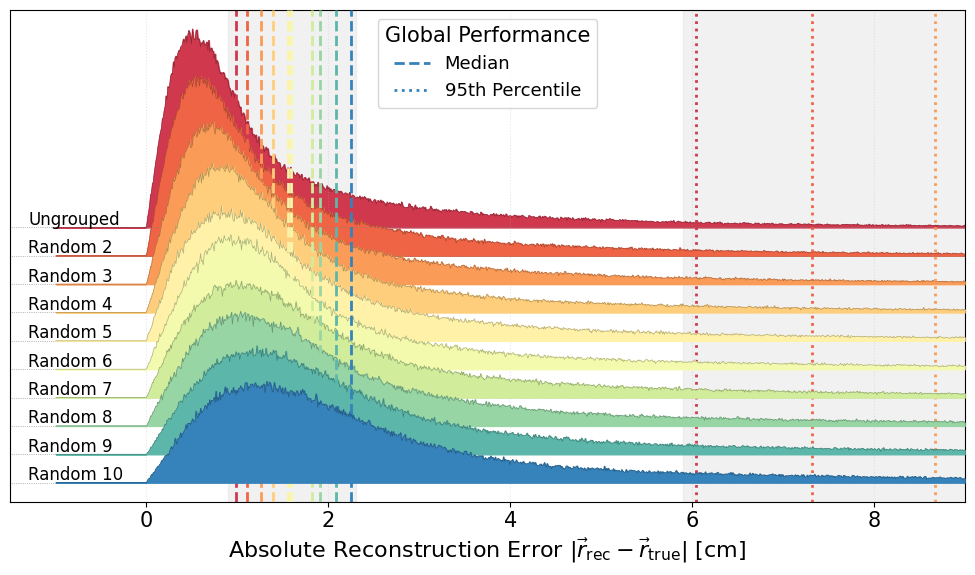

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# --- Configuration ---
area_key = 'area_10_1e5'
best_random_patterns = [
    "rand_02_82",
    "rand_03_47",
    "rand_04_91",
    "rand_05_76",
    "rand_06_28",
    "rand_07_69",
    "rand_08_64",
    "rand_09_34",
    "rand_10_94"
]

# --- Load all results dictionary ---
with open('/scratch/midway3/nkoebelin/mux_data_new/combined_results_ungrouped.pkl', 'rb') as f:
    combined_results_ungrouped = pickle.load(f)

with open('/scratch/midway3/nkoebelin/mux_data_new/selected_patterns_results.pkl', 'rb') as f:
    combined_results_scat = pickle.load(f)

# --- Build the `results` dict ---
results = {}

# Add best random patterns from selected_patterns_results
for name in best_random_patterns:
    if name in combined_results_scat and area_key in combined_results_scat[name]:
        results[name] = combined_results_scat[name][area_key]

# Add ungrouped model
if area_key in combined_results_ungrouped['ungrouped_1']:
    results['ungrouped_1'] = combined_results_ungrouped['ungrouped_1'][area_key]

# --- Label formatter ---
def format_model_name(name):
    if name == "ungrouped_1":
        return "Ungrouped"
    if name.startswith("rand_"):
        parts = name.split("_")
        if len(parts) >= 2:
            group_size = int(parts[1])  # Automatically strips leading zeros
            return f"Random {group_size}"
    return name

# --- Ridgeline plot function ---
def plot_error_ridgeline_histogram(results, bins=200, xlim=(0, 10), spacing=0.2, scale_factor=2.0, save_path=None):
    sorted_models = sorted(results.items(), key=lambda item: np.median(item[1]["abs_errors"]))
    n_models = len(sorted_models)

    fig, ax = plt.subplots(figsize=(10, n_models * 0.6))
    colors = sns.color_palette("Spectral", n_models)

    # Optional: vertical background spans
    ax.axvspan(0.9, 2.3, color='lightgray', alpha=0.3, zorder=0)
    ax.axvspan(5.9, 9.8, color='lightgray', alpha=0.3, zorder=0)

    max_height = 0
    histograms = []

    # Precompute histograms
    for model_name, data in sorted_models:
        abs_errors = data["abs_errors"]
        abs_errors = abs_errors[abs_errors <= xlim[1]]

        counts, bin_edges = np.histogram(abs_errors, bins=bins, range=xlim, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        histograms.append((model_name, bin_centers, counts))
        max_height = max(max_height, counts.max())

    # Plot from top to bottom
    for i, (model_name, bin_centers, counts) in enumerate(reversed(histograms)):
        y_shift = i * spacing
        z = n_models - i
        color_idx = n_models - 1 - i

        # Fill under histogram
        ax.fill_between(bin_centers, y_shift, counts * spacing * scale_factor / max_height + y_shift,
                        color=colors[color_idx], alpha=1.0, zorder=z)

        # Outline
        ax.plot(bin_centers, counts * spacing * scale_factor / max_height + y_shift,
                color=tuple(np.array(colors[color_idx]) * 0.7), lw=0.5, zorder=z)

        # Baseline
        ax.axhline(y=y_shift, color='gray', linestyle=':', linewidth=0.5)

        # Percentiles
        abs_errors = results[model_name]["abs_errors"]
        median = np.median(abs_errors)
        p95 = np.percentile(abs_errors, 95)

        median_label = 'Median' if i == 0 else None
        p95_label = '95th Percentile' if i == 0 else None

        ax.axvline(median, color=colors[color_idx], linestyle='--', lw=2.0, zorder=z + 0.1, label=median_label)
        ax.axvline(p95, color=colors[color_idx], linestyle=':', lw=2.0, zorder=z + 0.1, label=p95_label)

        # Label
        model_label = format_model_name(model_name)
        ax.text(xlim[0] - 0.3, y_shift + 0.04, model_label, ha='left', va='center', fontsize=12)

    # Axes settings
    ax.set_xlim(xlim[0] - 0.5, xlim[1])
    ax.set_ylim(-0.1, n_models * spacing + 1.0)
    ax.set_xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]")
    ax.set_yticks([])
    ax.legend(title="Global Performance", loc='upper center', fontsize=13, frameon=True, fancybox=True)
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# --- Run plot ---
plot_error_ridgeline_histogram(results, bins=1000, xlim=(-1.0, 9), spacing=0.15, scale_factor=7.0)#, save_path="random_all_ridgeline.png")


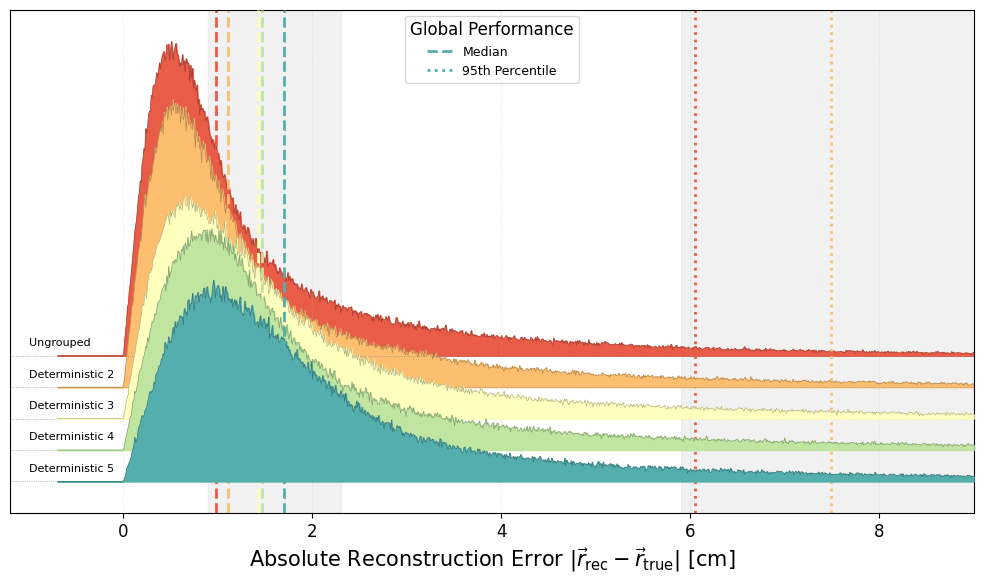

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Configuration ---
area_key = 'area_10_1e5'
best_deterministic_patterns = [
    "det_2_1_3_020",
    "det_3_1_2_020",
    "det_4_1_3_072",
    "det_5_1_2_122"
]

# --- Load all results dictionary ---
with open('/scratch/midway3/nkoebelin/mux_data_new/combined_results_ungrouped.pkl', 'rb') as f:
    combined_results_ungrouped = pickle.load(f)

with open('/scratch/midway3/nkoebelin/mux_data_new/selected_patterns_results.pkl', 'rb') as f:
    combined_results_scat = pickle.load(f)

# --- Build the `results` dict ---
results = {}

# Add best random patterns from selected_patterns_results
for name in best_deterministic_patterns:
    if name in combined_results_scat and area_key in combined_results_scat[name]:
        results[name] = combined_results_scat[name][area_key]

# Add ungrouped model
if area_key in combined_results_ungrouped['ungrouped_1']:
    results['ungrouped_1'] = combined_results_ungrouped['ungrouped_1'][area_key]

# --- Label formatter ---
def format_model_name(name):
    if name == "ungrouped_1":
        return "Ungrouped"
    if name.startswith("det_"):
        parts = name.split("_")
        if len(parts) >= 2:
            group_size = int(parts[1])  # Automatically strips leading zeros
            return f"Deterministic {group_size}"
    return name

# --- Ridgeline plot function ---
def plot_error_ridgeline_histogram(results, bins=200, xlim=(0, 10), spacing=0.2, scale_factor=2.0, save_path=None):
    sorted_models = sorted(results.items(), key=lambda item: np.median(item[1]["abs_errors"]))
    n_models = len(sorted_models)

    fig, ax = plt.subplots(figsize=(10, n_models * 1.2))
    colors = sns.color_palette("Spectral", n_models)

    # Optional: vertical background spans
    ax.axvspan(0.9, 2.3, color='lightgray', alpha=0.3, zorder=0)
    ax.axvspan(5.9, 9.8, color='lightgray', alpha=0.3, zorder=0)

    max_height = 0
    histograms = []

    # Precompute histograms
    for model_name, data in sorted_models:
        abs_errors = data["abs_errors"]
        abs_errors = abs_errors[abs_errors <= xlim[1]]

        counts, bin_edges = np.histogram(abs_errors, bins=bins, range=xlim, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        histograms.append((model_name, bin_centers, counts))
        max_height = max(max_height, counts.max())

    # Plot from top to bottom
    for i, (model_name, bin_centers, counts) in enumerate(reversed(histograms)):
        y_shift = i * spacing
        z = n_models - i
        color_idx = n_models - 1 - i

        # Fill under histogram
        ax.fill_between(bin_centers, y_shift, counts * spacing * scale_factor / max_height + y_shift,
                        color=colors[color_idx], alpha=1.0, zorder=z)

        # Outline
        ax.plot(bin_centers, counts * spacing * scale_factor / max_height + y_shift,
                color=tuple(np.array(colors[color_idx]) * 0.7), lw=0.5, zorder=z)

        # Baseline
        ax.axhline(y=y_shift, color='gray', linestyle=':', linewidth=0.5)

        # Percentiles
        abs_errors = results[model_name]["abs_errors"]
        median = np.median(abs_errors)
        p95 = np.percentile(abs_errors, 95)

        median_label = 'Median' if i == 0 else None
        p95_label = '95th Percentile' if i == 0 else None

        ax.axvline(median, color=colors[color_idx], linestyle='--', lw=2.0, zorder=z + 0.1, label=median_label)
        ax.axvline(p95, color=colors[color_idx], linestyle=':', lw=2.0, zorder=z + 0.1, label=p95_label)

        # Label
        model_label = format_model_name(model_name)
        ax.text(xlim[0] - 0.3, y_shift + 0.04, model_label, ha='left', va='center', fontsize=8)

    # Axes settings
    ax.set_xlim(xlim[0] - 0.5, xlim[1])
    ax.set_ylim(-0.1, n_models * spacing + 1.0)
    ax.set_xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]")
    ax.set_yticks([])
    ax.legend(title="Global Performance", loc='upper center', fontsize=9, frameon=True, fancybox=True)
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# --- Run plot ---
plot_error_ridgeline_histogram(results, bins=1000, xlim=(-0.7, 9), spacing=0.1, scale_factor=10.0)#, save_path="deterministic_all_ridgeline.png")


In [10]:
# Patterns that actually exist in combined_results
available_patterns = [
    "rand_02_82", "rand_03_47", "rand_04_91", "rand_05_76", "rand_06_28",
    "rand_07_69", "rand_08_64", "rand_09_34", "rand_10_94",
    "det_2_1_3_020", "det_3_1_2_020", "det_4_1_3_072", "det_5_1_2_122"
]

# Area key
area_key = 'area_10_1e5'

# Print header
print(f"{'Model':<20} | {'Median':>7} | {'68th':>7} | {'90th':>7} | {'95th':>7} | {'99th':>7}")
print("-" * 70)

# Table rows
for model in available_patterns:
    if model not in combined_results or area_key not in combined_results[model]:
        print(f"{model:<20} | Missing")
        continue

    stats = combined_results[model][area_key]
    print(f"{model:<20} | {stats['median_error']:7.3f} | {stats['68th_percentile']:7.3f} | "
          f"{stats['90th_percentile']:7.3f} | {stats['95th_percentile']:7.3f} | {stats['99th_percentile']:7.3f}")


Model                |  Median |    68th |    90th |    95th |    99th
----------------------------------------------------------------------
rand_02_82           |   1.108 |   1.803 |   4.783 |   7.318 |  16.641
rand_03_47           |   1.262 |   2.006 |   5.435 |   8.666 |  21.851
rand_04_91           |   1.387 |   2.146 |   6.178 |  10.484 |  29.935
rand_05_76           |   1.561 |   2.465 |   7.383 |  12.948 |  35.873
rand_06_28           |   1.595 |   2.501 |   7.845 |  14.297 |  39.980
rand_07_69           |   1.817 |   2.862 |   8.921 |  16.117 |  41.698
rand_08_64           |   1.910 |   3.053 |  10.448 |  19.775 |  49.845
rand_09_34           |   2.083 |   3.269 |  11.353 |  21.189 |  51.532
rand_10_94           |   2.249 |   3.596 |  13.578 |  24.967 |  55.617
det_2_1_3_020        |   1.107 |   1.824 |   4.854 |   7.486 |  17.356
det_3_1_2_020        |   1.424 |   2.228 |   5.815 |   9.051 |  21.387
det_4_1_3_072        |   1.465 |   2.285 |   6.510 |  10.692 |  27.398
det_5_

In [20]:
# Patterns that actually exist in combined_results
available_patterns = [
    "rand_02_82", "rand_03_47", "rand_04_91", "rand_05_76", "rand_06_28",
    "rand_07_69", "rand_08_64", "rand_09_34", "rand_10_94",
    "det_2_1_3_020", "det_3_1_2_020", "det_4_1_3_072", "det_5_1_2_122"
]

# Area key
area_key = 'area_200_2000'

# Print header
print(f"{'Model':<20} | {'Median':>7} | {'68th':>7} | {'90th':>7} | {'95th':>7} | {'99th':>7}")
print("-" * 70)

# Table rows
for model in available_patterns:
    if model not in combined_results or area_key not in combined_results[model]:
        print(f"{model:<20} | Missing")
        continue

    stats = combined_results[model][area_key]
    print(f"{model:<20} | {stats['median_error']:7.3f} | {stats['68th_percentile']:7.3f} | "
          f"{stats['90th_percentile']:7.3f} | {stats['95th_percentile']:7.3f} | {stats['99th_percentile']:7.3f}")


Model                |  Median |    68th |    90th |    95th |    99th
----------------------------------------------------------------------
rand_02_82           |   1.226 |   1.639 |   2.597 |   3.118 |   4.296
rand_03_47           |   1.376 |   1.836 |   2.892 |   3.482 |   4.791
rand_04_91           |   1.501 |   1.985 |   3.093 |   3.716 |   5.169
rand_05_76           |   1.678 |   2.247 |   3.565 |   4.327 |   6.167
rand_06_28           |   1.719 |   2.290 |   3.610 |   4.397 |   6.394
rand_07_69           |   1.928 |   2.592 |   4.170 |   5.141 |   7.712
rand_08_64           |   2.052 |   2.752 |   4.437 |   5.461 |   8.402
rand_09_34           |   2.223 |   2.979 |   4.788 |   5.935 |   9.403
rand_10_94           |   2.449 |   3.305 |   5.492 |   6.957 |  11.800
det_2_1_3_020        |   1.226 |   1.650 |   2.636 |   3.196 |   4.446
det_3_1_2_020        |   1.498 |   2.019 |   3.228 |   3.902 |   5.437
det_4_1_3_072        |   1.583 |   2.113 |   3.340 |   4.019 |   5.647
det_5_

In [21]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
scattered_models = [
    'det_2_1_3_020', 'det_3_1_2_020', 'det_4_1_3_072', 'det_5_1_2_122',
    'rand_02_82', 'rand_03_47', 'rand_04_91', 'rand_05_76', 'rand_06_28',
    'rand_07_69', 'rand_08_64', 'rand_09_34', 'rand_10_94'
]

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Scattered model wall leakage analysis ---
print("=== Wall Leakage Percentages – Scattered Groupings ===")

for area_min, area_max, area_label in split_ranges:
    print(f"\n--- Area Range: {area_label} ---")
    
    for model in scattered_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model}: File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model}: Missing required data keys.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

        mask_area = (area >= area_min) & (area <= area_max)
        r_true = np.linalg.norm(pos_test[mask_area], axis=1)
        r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

        mask_outer = r_true >= 60
        mask_leak = r_pred[mask_outer] < 60

        if np.sum(mask_outer) > 0:
            percent = 100 * np.sum(mask_leak) / np.sum(mask_outer)
            print(f"{model:<18} : {percent:5.2f}% of r_true ≥ 60 cm have r_pred < 60 cm")
        else:
            print(f"{model:<18} : No outer events to evaluate.")


=== Wall Leakage Percentages – Scattered Groupings ===

--- Area Range: 10–50 PE ---
det_2_1_3_020      : 53.81% of r_true ≥ 60 cm have r_pred < 60 cm
det_3_1_2_020      : 58.95% of r_true ≥ 60 cm have r_pred < 60 cm
det_4_1_3_072      : 62.70% of r_true ≥ 60 cm have r_pred < 60 cm
det_5_1_2_122      : 65.11% of r_true ≥ 60 cm have r_pred < 60 cm
rand_02_82         : 54.38% of r_true ≥ 60 cm have r_pred < 60 cm
rand_03_47         : 60.31% of r_true ≥ 60 cm have r_pred < 60 cm
rand_04_91         : 65.93% of r_true ≥ 60 cm have r_pred < 60 cm
rand_05_76         : 70.73% of r_true ≥ 60 cm have r_pred < 60 cm
rand_06_28         : 72.62% of r_true ≥ 60 cm have r_pred < 60 cm
rand_07_69         : 77.58% of r_true ≥ 60 cm have r_pred < 60 cm
rand_08_64         : 80.45% of r_true ≥ 60 cm have r_pred < 60 cm
rand_09_34         : 82.96% of r_true ≥ 60 cm have r_pred < 60 cm
rand_10_94         : 84.94% of r_true ≥ 60 cm have r_pred < 60 cm

--- Area Range: 200–2000 PE ---
det_2_1_3_020      :  6.

In [2]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
adj_models = [
    'det_2_1_3_020', 'det_3_1_2_020', 'det_4_1_3_072', 'det_5_1_2_122',
    'rand_02_82', 'rand_03_47', 'rand_04_91', 'rand_05_76', 'rand_06_28',
    'rand_07_69', 'rand_08_64', 'rand_09_34', 'rand_10_94'
]
wall_threshold = 61.35  # cm
r_cut_scan = np.arange(50, 70, 0.01)

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Helper to get leakage rate ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr=wall_threshold, r_cut=None):
    mask_area = (area >= area_min) & (area <= area_max)
    r_true = np.linalg.norm(pos_test[mask_area], axis=1)
    r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

    mask_outer = r_true >= wall_thr
    if r_cut is None:
        # Use default leakage definition (r_pred < wall_thr)
        mask_leak = r_pred[mask_outer] < wall_thr
    else:
        # Custom r_cut
        mask_leak = r_pred[mask_outer] < r_cut

    n_outer = np.sum(mask_outer)
    n_leak = np.sum(mask_leak)
    if n_outer == 0:
        return None
    return 100 * n_leak / n_outer

# --- Compute reference leakage for ungrouped ---
ungrouped_leakage = {}

for area_min, area_max, area_label in split_ranges:
    rates = []
    for model_key in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model_key}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                continue
            leakage = compute_leakage(data["pos_test"], data["pos_pred"], data["area_test"],
                                      area_min, area_max, wall_threshold)
            if leakage is not None:
                rates.append(leakage)

    if rates:
        avg = np.mean(rates)
        max_dev = np.max(np.abs(np.array(rates) - avg))
        ungrouped_leakage[area_label] = avg
        print(f"\nUngrouped ({area_label}): {avg:.2f}% ± {max_dev:.2f}% leakage (r_true ≥ {wall_threshold})")
    else:
        print(f"\nUngrouped ({area_label}): No valid data across training runs.")

# --- Find matching r_cut for adjacent models ---
print("\n=== Matched Leakage r_cut values for Adjacent Models ===")
for area_min, area_max, area_label in split_ranges:
    ref_leakage = ungrouped_leakage.get(area_label)
    if ref_leakage is None:
        continue

    for model in adj_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model} ({area_label}): File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model} ({area_label}): Missing keys.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

            # Scan for best r_cut
            best_r_cut = None
            min_diff = np.inf
            for r_cut in r_cut_scan:
                leakage = compute_leakage(pos_test, pos_pred, area,
                                          area_min, area_max, wall_thr=r_cut,
                                          r_cut=r_cut)
                if leakage is None:
                    continue
                diff = abs(leakage - ref_leakage)
                if diff < min_diff:
                    min_diff = diff
                    best_r_cut = r_cut

            if best_r_cut is not None:
                print(f"{model} ({area_label}): r_cut = {best_r_cut:.2f} cm → leakage ≈ {ref_leakage:.2f}%")
            else:
                print(f"{model} ({area_label}): Could not determine r_cut.")



Ungrouped (10–50 PE): 55.08% ± 1.87% leakage (r_true ≥ 61.35)

Ungrouped (200–2000 PE): 10.10% ± 2.12% leakage (r_true ≥ 61.35)

Ungrouped (1e4–1e5 PE): 1.74% ± 1.05% leakage (r_true ≥ 61.35)

=== Matched Leakage r_cut values for Adjacent Models ===
det_2_1_3_020 (10–50 PE): r_cut = 60.15 cm → leakage ≈ 55.08%
det_3_1_2_020 (10–50 PE): r_cut = 59.29 cm → leakage ≈ 55.08%
det_4_1_3_072 (10–50 PE): r_cut = 58.47 cm → leakage ≈ 55.08%
det_5_1_2_122 (10–50 PE): r_cut = 57.63 cm → leakage ≈ 55.08%
rand_02_82 (10–50 PE): r_cut = 60.09 cm → leakage ≈ 55.08%
rand_03_47 (10–50 PE): r_cut = 59.06 cm → leakage ≈ 55.08%
rand_04_91 (10–50 PE): r_cut = 57.84 cm → leakage ≈ 55.08%
rand_05_76 (10–50 PE): r_cut = 56.31 cm → leakage ≈ 55.08%
rand_06_28 (10–50 PE): r_cut = 55.21 cm → leakage ≈ 55.08%
rand_07_69 (10–50 PE): r_cut = 53.53 cm → leakage ≈ 55.08%
rand_08_64 (10–50 PE): r_cut = 50.42 cm → leakage ≈ 55.08%
rand_09_34 (10–50 PE): r_cut = 50.00 cm → leakage ≈ 55.08%


KeyboardInterrupt: 

In [6]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
scat_models = [
    'det_2_1_3_020', 'det_3_1_2_020', 'det_4_1_3_072', 'det_5_1_2_122',
    'rand_02_82', 'rand_03_47', 'rand_04_91', 'rand_05_76', 'rand_06_28',
    'rand_07_69', 'rand_08_64', 'rand_09_34', 'rand_10_94'
]
r_cut_scan = np.arange(45, 65, 0.01)

split_ranges = [
    #(10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE')#,
    #(1e4, 1e5, '1e4–1e5 PE')
]

# --- Leakage helper ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr, r_cut):
    mask_area = (area >= area_min) & (area <= area_max)
    r_true = np.linalg.norm(pos_test[mask_area], axis=1)
    r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

    mask_outer = r_true >= wall_thr
    mask_leak = r_pred[mask_outer] < r_cut

    n_outer = np.sum(mask_outer)
    n_leak = np.sum(mask_leak)
    if n_outer == 0:
        return None
    return 100 * n_leak / n_outer

# --- Step 1: Collect min and max leakage from ungrouped runs ---
ungrouped_leakage_bounds = {}

for area_min, area_max, area_label in split_ranges:
    rates = []
    for model_key in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model_key}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                continue
            leakage = compute_leakage(
                data["pos_test"], data["pos_pred"], data["area_test"],
                area_min, area_max,
                wall_thr=61.35, r_cut=61.35
            )
            if leakage is not None:
                rates.append(leakage)

    if rates:
        rates = np.array(rates)
        min_leak, max_leak = np.min(rates), np.max(rates)
        ungrouped_leakage_bounds[area_label] = (min_leak, max_leak)
        print(f"\nUngrouped ({area_label}): min = {min_leak:.2f}%, max = {max_leak:.2f}% leakage (r ≥ 60)")
    else:
        print(f"\nUngrouped ({area_label}): No valid leakage data.")

# --- Step 2: Scan scattered models for matching r_cut values ---
print("\n=== r_cut ranges matching Ungrouped Leakage ===")

for area_min, area_max, area_label in split_ranges:
    bounds = ungrouped_leakage_bounds.get(area_label)
    if bounds is None:
        continue
    min_leakage, max_leakage = bounds

    for model in scat_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model} ({area_label}): File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model} ({area_label}): Missing keys.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

            best_r_min, best_r_max = None, None
            min_diff_low, min_diff_high = np.inf, np.inf

            for r_cut in r_cut_scan:
                leakage = compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr=r_cut, r_cut=r_cut)
                if leakage is None:
                    continue

                diff_low = abs(leakage - min_leakage)
                diff_high = abs(leakage - max_leakage)

                if diff_low < min_diff_low:
                    min_diff_low = diff_low
                    best_r_min = r_cut
                if diff_high < min_diff_high:
                    min_diff_high = diff_high
                    best_r_max = r_cut

            if best_r_min is not None and best_r_max is not None:
                print(f"{model} ({area_label}): r_cut range = [{best_r_min:.2f}, {best_r_max:.2f}] cm "
                      f"→ matches ungrouped leakage [{min_leakage:.2f}%, {max_leakage:.2f}%]")
            else:
                print(f"{model} ({area_label}): Could not determine full r_cut range.")



Ungrouped (200–2000 PE): min = 8.42%, max = 12.21% leakage (r ≥ 60)

=== r_cut ranges matching Ungrouped Leakage ===
det_2_1_3_020 (200–2000 PE): r_cut range = [60.36, 60.95] cm → matches ungrouped leakage [8.42%, 12.21%]
det_3_1_2_020 (200–2000 PE): r_cut range = [60.27, 60.87] cm → matches ungrouped leakage [8.42%, 12.21%]
det_4_1_3_072 (200–2000 PE): r_cut range = [60.11, 60.75] cm → matches ungrouped leakage [8.42%, 12.21%]
det_5_1_2_122 (200–2000 PE): r_cut range = [60.36, 61.04] cm → matches ungrouped leakage [8.42%, 12.21%]
rand_02_82 (200–2000 PE): r_cut range = [60.75, 61.28] cm → matches ungrouped leakage [8.42%, 12.21%]
rand_03_47 (200–2000 PE): r_cut range = [60.15, 60.81] cm → matches ungrouped leakage [8.42%, 12.21%]
rand_04_91 (200–2000 PE): r_cut range = [60.25, 60.75] cm → matches ungrouped leakage [8.42%, 12.21%]
rand_05_76 (200–2000 PE): r_cut range = [59.04, 60.02] cm → matches ungrouped leakage [8.42%, 12.21%]
rand_06_28 (200–2000 PE): r_cut range = [59.35, 60.30]

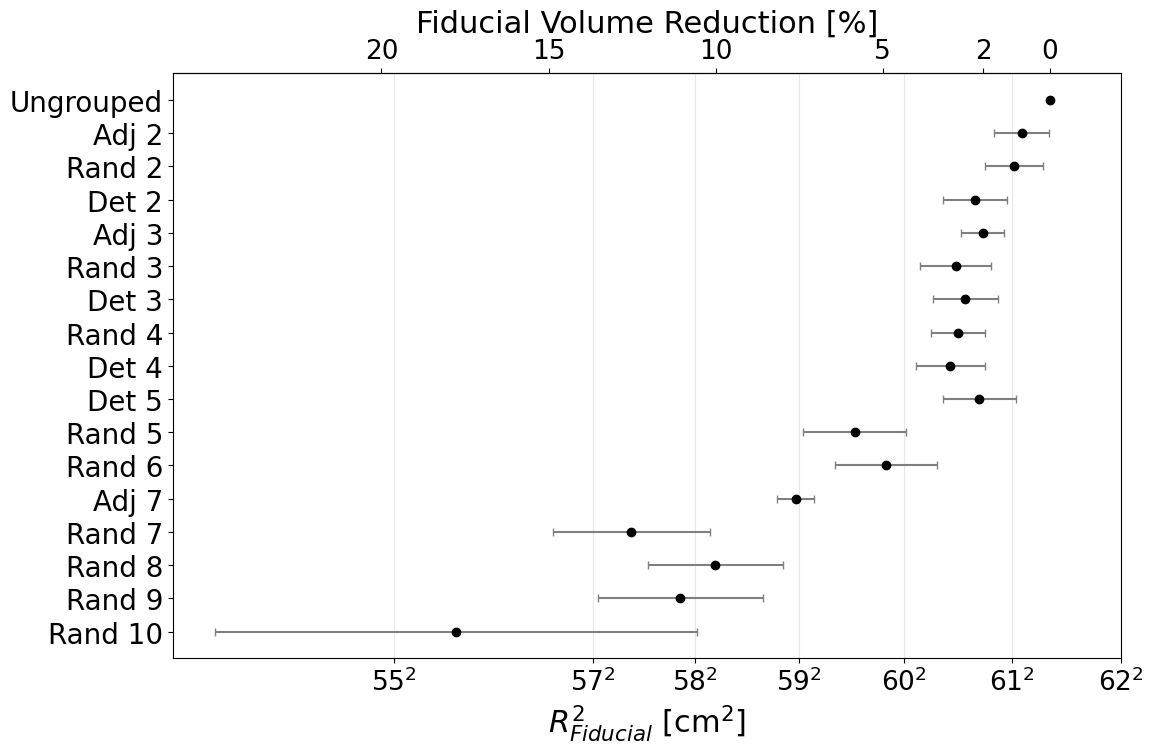

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 22,          # Base size for ticks
    "axes.labelsize": 22,     # x/y label size
    "axes.titlesize": 20,     # Title size
    "xtick.labelsize": 19,
    "ytick.labelsize": 20,
    "legend.fontsize": 18
})

# --- Data: reordered by group size ---
models = [
    "Ungrouped", "Adj 2", "Rand 2", "Det 2",
    "Adj 3", "Rand 3", "Det 3",
    "Rand 4", "Det 4",
    "Det 5", "Rand 5",
    "Rand 6", "Adj 7",
    "Rand 7", "Rand 8", "Rand 9", "Rand 10"
]
r_cuts = np.array([
    61.35, 61.09, 61.02, 60.66,
    60.73, 60.48, 60.57,
    60.50, 60.43,
    60.70, 59.53,
    59.83, 58.97,
    57.38, 58.20, 57.86, 55.63
])
errors = np.array([
    0.00, 0.25, 0.27, 0.30,
    0.20, 0.33, 0.30,
    0.25, 0.32,
    0.34, 0.49,
    0.48, 0.18,
    0.77, 0.65, 0.80, 2.44
])
vol_reduction = np.array([
    0.00, 0.85, 0.53, 2.25,
    2.01, 3.10, 2.54,
    3.05, 2.94,
    2.13, 5.89,
    5.16, 7.61,
    12.86, 10.19, 11.03, 17.81
])

# --- Convert to r² and compute volume reduction ---
r2_cuts = r_cuts**2
r2_errors = 2 * r_cuts * errors
r2_ref = r2_cuts[0]  # ungrouped

def r2_to_reduction(r2):
    return 100 * (1 - r2 / r2_ref)

def reduction_to_r2(reduction):
    return r2_ref * (1 - reduction / 100)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 8))
y_pos = np.arange(len(models))

# Main errorbar plot
ax.errorbar(r2_cuts, y_pos, xerr=r2_errors, fmt='o', color='black',
            ecolor='gray', elinewidth=1.5, capsize=3)

# Custom tick labels for x-axis (squared format)
x_ticks_raw = np.array([55, 57, 58, 59, 60, 61, 62])
x_tick_pos = x_ticks_raw**2
x_tick_labels = [f"${x}^2$" for x in x_ticks_raw]

ax.set_xticks(x_tick_pos)
ax.set_xticklabels(x_tick_labels)

# Y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis()
#ax.set_xlabel(r"$r_\mathrm{cut}^2$ [cm$^2$]")
ax.set_xlabel(r"$R_{Fiducial}^2$ [cm$^2$]")
ax.grid(axis='x', alpha=0.3)

# Top x-axis for volume reduction
secax = ax.secondary_xaxis('top', functions=(r2_to_reduction, reduction_to_r2))
secax.set_xlabel("Fiducial Volume Reduction [%]")
secax.set_xticks([0, 2, 5, 10, 15, 20])
secax.set_xlim(ax.get_xlim())

# Title
#plt.title("Fiducial Radius Matching Ungrouped Leakage (200–2000 PE)", fontsize=16)
plt.tight_layout()
#plt.savefig("fiducial_volume_reduction_sorted.png", dpi=300)
plt.show()


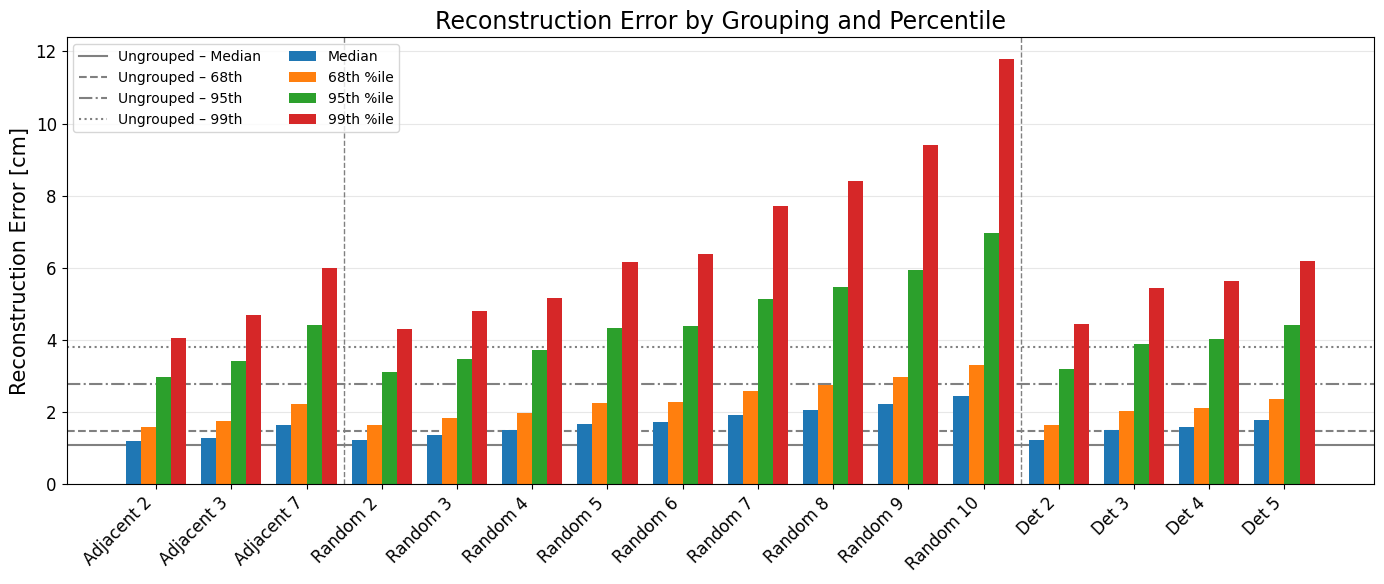

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# --- Group labels and grouping types ---
group_labels = [
    "Adjacent 2", "Adjacent 3", "Adjacent 7",
    "Random 2", "Random 3", "Random 4", "Random 5", "Random 6", "Random 7", "Random 8", "Random 9", "Random 10",
    "Det 2", "Det 3", "Det 4", "Det 5"
]
group_types = [
    "Adjacent", "Adjacent", "Adjacent",
    "Random", "Random", "Random", "Random", "Random", "Random", "Random", "Random", "Random",
    "Deterministic", "Deterministic", "Deterministic", "Deterministic"
]

# --- Error data ---
median_errors = [1.203, 1.289, 1.637, 1.226, 1.376, 1.501, 1.678, 1.719, 1.928, 2.052, 2.223, 2.449,
                 1.226, 1.498, 1.583, 1.770]
p68_errors    = [1.597, 1.746, 2.231, 1.639, 1.836, 1.985, 2.247, 2.290, 2.592, 2.752, 2.979, 3.305,
                 1.650, 2.019, 2.113, 2.359]
p95_errors    = [2.983, 3.426, 4.422, 3.118, 3.482, 3.716, 4.327, 4.397, 5.141, 5.461, 5.935, 6.957,
                 3.196, 3.902, 4.019, 4.420]
p99_errors    = [4.042, 4.695, 6.005, 4.296, 4.791, 5.169, 6.167, 6.394, 7.712, 8.402, 9.403, 11.800,
                 4.446, 5.437, 5.647, 6.176]

# --- Ungrouped reference values ---
ungrouped = {
    "Median": 1.100,
    "68th": 1.472,
    "95th": 2.783,
    "99th": 3.805
}

# --- Setup figure ---
fig, ax = plt.subplots(figsize=(14, 6))

# --- Bar setup ---
N = len(group_labels)
x = np.arange(N)
bar_width = 0.2

# --- Vertical divider lines between grouping types ---
dividers = [2.5, 11.5]  # after last Adjacent and last Random
for xpos in dividers:
    ax.axvline(x=xpos, color='gray', linestyle='--', linewidth=1)


# --- Plot bars ---
ax.bar(x - 1.5*bar_width, median_errors, width=bar_width, label='Median', color='C0', zorder=2)
ax.bar(x - 0.5*bar_width, p68_errors, width=bar_width, label='68th %ile', color='C1', zorder=2)
ax.bar(x + 0.5*bar_width, p95_errors, width=bar_width, label='95th %ile', color='C2', zorder=2)
ax.bar(x + 1.5*bar_width, p99_errors, width=bar_width, label='99th %ile', color='C3', zorder=2)

# --- Ungrouped reference lines ---
linestyles = {"Median": "solid", "68th": "dashed", "95th": "dashdot", "99th": "dotted"}
for percentile, y in ungrouped.items():
    ax.axhline(y, linestyle=linestyles[percentile], color='gray', linewidth=1.5,
               label=f'Ungrouped – {percentile}', zorder=1)

# --- Axis formatting ---
ax.set_xticks(x)
ax.set_xticklabels(group_labels, rotation=45, ha='right')
ax.set_ylabel("Reconstruction Error [cm]")
ax.set_title("Reconstruction Error by Grouping and Percentile")
ax.grid(True, axis='y', alpha=0.3, zorder=0)

# --- Custom legends ---
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=2, fontsize=10, loc="upper left")

plt.tight_layout()
plt.show()


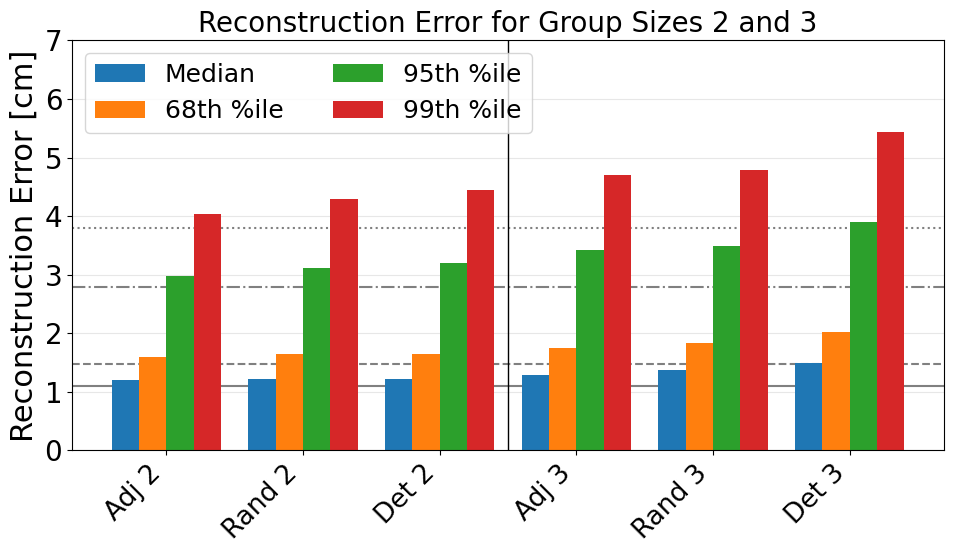

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# --- Group labels sorted by group size, then model type ---
group_labels = [
    "Adj 2", "Rand 2", "Det 2",
    "Adj 3", "Rand 3", "Det 3"
]

# --- Corresponding error values sorted accordingly ---
median_errors = [1.203, 1.226, 1.226, 1.289, 1.376, 1.498]
p68_errors    = [1.597, 1.639, 1.650, 1.746, 1.836, 2.019]
p95_errors    = [2.983, 3.118, 3.196, 3.426, 3.482, 3.902]
p99_errors    = [4.042, 4.296, 4.446, 4.695, 4.791, 5.437]

# --- Ungrouped reference values (not added to legend) ---
ungrouped = {
    "Median": 1.100,
    "68th": 1.472,
    "95th": 2.783,
    "99th": 3.805
}

# --- Setup plot ---
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(group_labels))
bar_width = 0.2

# --- Divider lines between group sizes (after group size 2) ---
ax.axvline(x=2.5, color='k', linestyle='-', linewidth=1)

# --- Plot grouped bars ---
ax.bar(x - 1.5*bar_width, median_errors, width=bar_width, label='Median', color='C0', zorder=2)
ax.bar(x - 0.5*bar_width, p68_errors, width=bar_width, label='68th %ile', color='C1', zorder=2)
ax.bar(x + 0.5*bar_width, p95_errors, width=bar_width, label='95th %ile', color='C2', zorder=2)
ax.bar(x + 1.5*bar_width, p99_errors, width=bar_width, label='99th %ile', color='C3', zorder=2)

# --- Reference lines (not in legend) ---
linestyles = {"Median": "solid", "68th": "dashed", "95th": "dashdot", "99th": "dotted"}
for y, style in zip(ungrouped.values(), linestyles.values()):
    ax.axhline(y, linestyle=style, color='gray', linewidth=1.5, zorder=1)

# --- Axis formatting ---
ax.set_xticks(x)
ax.set_xticklabels(group_labels, rotation=45, ha='right')
ax.set_ylabel("Reconstruction Error [cm]")
ax.set_title("Reconstruction Error for Group Sizes 2 and 3")
ax.grid(True, axis='y', alpha=0.3, zorder=0)
ax.set_ylim(0,7)

# --- Legend (exclude ungrouped lines) ---
handles, labels = ax.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if not l.startswith("Ungrouped")]
ax.legend(*zip(*filtered), ncol=2, loc="upper left")

plt.tight_layout()
plt.show()


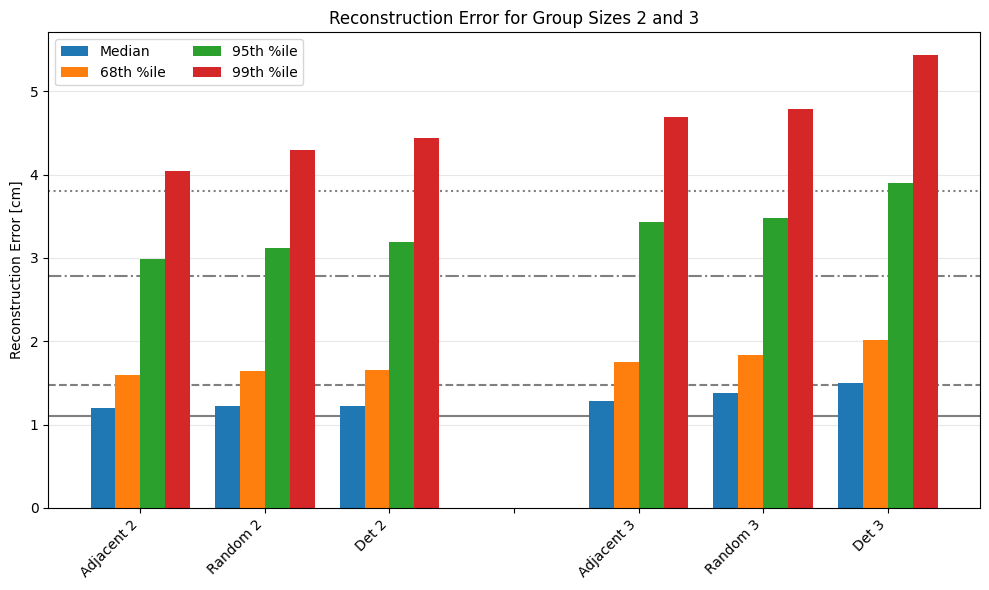

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- Updated labels and data with spacer ---
group_labels = [
    "Adjacent 2", "Random 2", "Det 2", "",  # spacer
    "Adjacent 3", "Random 3", "Det 3"
]

median_errors = [1.203, 1.226, 1.226, np.nan, 1.289, 1.376, 1.498]
p68_errors    = [1.597, 1.639, 1.650, np.nan, 1.746, 1.836, 2.019]
p95_errors    = [2.983, 3.118, 3.196, np.nan, 3.426, 3.482, 3.902]
p99_errors    = [4.042, 4.296, 4.446, np.nan, 4.695, 4.791, 5.437]

# --- Ungrouped reference values (not in legend) ---
ungrouped = {
    "Median": 1.100,
    "68th": 1.472,
    "95th": 2.783,
    "99th": 3.805
}

# --- Setup plot ---
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(group_labels))
bar_width = 0.2

# --- Plot grouped bars, np.nan bars will be skipped ---
ax.bar(x - 1.5*bar_width, median_errors, width=bar_width, label='Median', color='C0', zorder=2)
ax.bar(x - 0.5*bar_width, p68_errors, width=bar_width, label='68th %ile', color='C1', zorder=2)
ax.bar(x + 0.5*bar_width, p95_errors, width=bar_width, label='95th %ile', color='C2', zorder=2)
ax.bar(x + 1.5*bar_width, p99_errors, width=bar_width, label='99th %ile', color='C3', zorder=2)

# --- Reference lines (not in legend) ---
linestyles = {"Median": "solid", "68th": "dashed", "95th": "dashdot", "99th": "dotted"}
for y, style in zip(ungrouped.values(), linestyles.values()):
    ax.axhline(y, linestyle=style, color='gray', linewidth=1.5, zorder=1)

# --- Axis formatting ---
ax.set_xticks(x)
ax.set_xticklabels(group_labels, rotation=45, ha='right')
ax.set_ylabel("Reconstruction Error [cm]")
ax.set_title("Reconstruction Error for Group Sizes 2 and 3")
ax.grid(True, axis='y', alpha=0.3, zorder=0)

# --- Legend (exclude ungrouped lines) ---
handles, labels = ax.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if not l.startswith("Ungrouped")]
ax.legend(*zip(*filtered), ncol=2, loc="upper left")

plt.tight_layout()
plt.show()


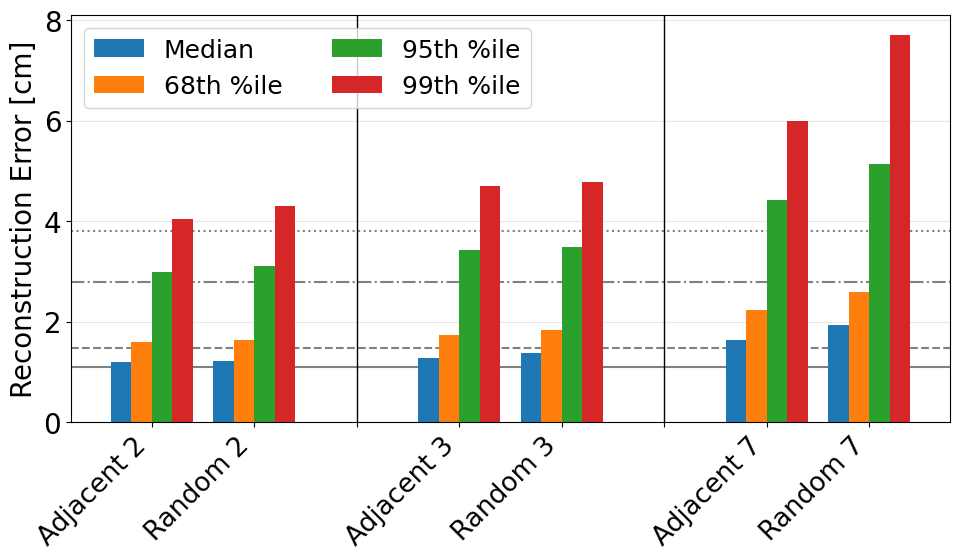

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 20,          # Base size for ticks
    "axes.labelsize": 20,     # x/y label size
    "axes.titlesize": 20,     # Title size
    "xtick.labelsize": 19,
    "ytick.labelsize": 20,
    "legend.fontsize": 18
})

# --- Updated labels and data with spacers ---
group_labels = [
    "Adjacent 2", "Random 2", "",  # spacer
    "Adjacent 3", "Random 3", "",  # spacer
    "Adjacent 7", "Random 7"
]

median_errors = [1.203, 1.226, np.nan, 1.289, 1.376, np.nan, 1.637, 1.928]
p68_errors    = [1.597, 1.639, np.nan, 1.746, 1.836, np.nan, 2.231, 2.592]
p95_errors    = [2.983, 3.118, np.nan, 3.426, 3.482, np.nan, 4.422, 5.141]
p99_errors    = [4.042, 4.296, np.nan, 4.695, 4.791, np.nan, 6.005, 7.712]

# --- Ungrouped reference values (not in legend) ---
ungrouped = {
    "Median": 1.100,
    "68th": 1.472,
    "95th": 2.783,
    "99th": 3.805
}

# --- Setup plot ---
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(group_labels))
bar_width = 0.2

# --- Divider lines between group sizes (after group size 2) ---
ax.axvline(x=2, color='k', linestyle='-', linewidth=1)
ax.axvline(x=5, color='k', linestyle='-', linewidth=1)

# --- Plot grouped bars, np.nan bars will be skipped ---
ax.bar(x - 1.5*bar_width, median_errors, width=bar_width, label='Median', color='C0', zorder=2)
ax.bar(x - 0.5*bar_width, p68_errors, width=bar_width, label='68th %ile', color='C1', zorder=2)
ax.bar(x + 0.5*bar_width, p95_errors, width=bar_width, label='95th %ile', color='C2', zorder=2)
ax.bar(x + 1.5*bar_width, p99_errors, width=bar_width, label='99th %ile', color='C3', zorder=2)

# --- Reference lines (not in legend) ---
linestyles = {"Median": "solid", "68th": "dashed", "95th": "dashdot", "99th": "dotted"}
for y, style in zip(ungrouped.values(), linestyles.values()):
    ax.axhline(y, linestyle=style, color='gray', linewidth=1.5, zorder=1)

# --- Axis formatting ---
ax.set_xticks(x)
ax.set_xticklabels(group_labels, rotation=45, ha='right')
ax.set_ylabel("Reconstruction Error [cm]")
#ax.set_title("Reconstruction Error by Grouping (Sizes 2, 3, 7)")
ax.grid(True, axis='y', alpha=0.3, zorder=0)

# --- Legend (exclude ungrouped lines) ---
handles, labels = ax.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if not l.startswith("Ungrouped")]
ax.legend(*zip(*filtered), ncol=2, loc="upper left")

plt.tight_layout()
#plt.savefig("rec_err_bargraph_adj_rand_237.png", dpi=300)
plt.show()


In [7]:
print("Available models in combined_results:")
print(sorted(combined_results.keys()))


Available models in combined_results:
['det_2_1_3_020', 'det_3_1_2_020', 'det_4_1_3_072', 'det_5_1_2_122', 'rand_02_82', 'rand_03_47', 'rand_04_91', 'rand_05_76', 'rand_06_28', 'rand_07_69', 'rand_08_64', 'rand_09_34', 'rand_10_94', 'ungrouped_1', 'ungrouped_10', 'ungrouped_2', 'ungrouped_3', 'ungrouped_4', 'ungrouped_5', 'ungrouped_6', 'ungrouped_7', 'ungrouped_8', 'ungrouped_9']


In [9]:
sample_model = 'rand_02_82'  # or any other model you know should be there
if sample_model in combined_results:
    print(f"Available area keys for '{sample_model}':")
    print(combined_results[sample_model].keys())


Available area keys for 'rand_02_82':
dict_keys(['area_200_2000', 'area_10_50', 'area_1e4_1e5', 'area_10_1e5'])


In [2]:
# Load supporting files
idx_test_array = np.load("idx_test_global.npy")
lookup_dict = np.load("global_index_lookup.npy", allow_pickle=True).item()
pmt_xy_top = np.load("hex_pattern_data.npz", allow_pickle=True)["pmt_xy_top"]
mux_patterns = np.load("mux_patterns_all_new.npz", allow_pickle=True)
raw_data_path = "/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/"
rns = np.load("mux_patterns_all_new.npz", allow_pickle=True)

In [78]:
def plot_hitpattern_event(
    mux_name,
    test_idx,
    raw_data_path,
    npz_data_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images",
    #filename=None,
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    os.makedirs(image_dir, exist_ok=True)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    # --- Font size setup to match reference layout ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    # --- same as before ---
    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
    groups = [np.array(g) for g in mux]

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    npz = np.load(npz_data_path)
    pred = npz["pos_pred"][test_idx]
    true = npz["pos_test"][test_idx]
    abs_err = npz["abs_errors"][test_idx]

   # group_values = np.zeros(len(groups))
    #for i, group in enumerate(groups):
     #   if len(group) > 0:
      #      group_values[i] = np.sum(hitpattern[group])

    #pmt_intensity = np.zeros(PMTs_top)
    #for i, group in enumerate(groups):
     #   if len(group) > 0:
      #      pmt_intensity[group] = group_values[i] / len(group)

    # Plot
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(pmt_x_top, pmt_y_top, c=hitpattern, cmap='viridis', marker='o', s=700, norm=LogNorm())
    plt.colorbar(sc, label='S2 Area [PE]')
    plt.scatter(interface_x, interface_y, c='red', marker='o', s=100, label='MC Position')
    plt.scatter(pred[0], pred[1], c='k', marker='+', s=200, label=f'Reconstruction\nError={abs_err:.2f} cm')

    circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
    plt.gca().add_patch(circle)

    #plt.title(f"{mux_name} | TestIdx={test_idx}, S2 Area={s2_area:.1f}, Error={abs_err:.2f} cm")
    plt.title(f"Ungrouped | S2 Area={s2_area:.1f}")
    plt.xlabel("X [cm]")
    plt.ylabel("Y [cm]")
    plt.axis('equal')
    plt.grid(alpha=0.2)
    plt.legend(loc="upper left")
    plt.tight_layout()

    if save_image:
        default_name = f"{mux_name}_event{test_idx}.png"
        plt.savefig(os.path.join(image_dir, default_name), dpi=300)
        print(f"Saved: {os.path.join(image_dir, default_name)}")

    plt.show()

In [114]:
def plot_hitpattern_grid(
    test_idx,
    raw_data_path,
    base_npz_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    # --- Font size setup to match reference layout ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    # Define models and titles
    mux_names = ["adj_2", "adj_3", "adj_7", "rand_02_82", "rand_03_47", "rand_07_69"]
    titles = ["Adjacent 2", "Adjacent 3", "Adjacent 7",
              "Random 2", "Random 3", "Random 7"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    all_pmt_intensities = []

    # First pass to compute global vmin and vmax
    for mux_name in mux_names:
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [np.array(g) for g in mux]

        group_values = np.zeros(len(groups))
        for j, group in enumerate(groups):
            if len(group) > 0:
                group_values[j] = np.sum(hitpattern[group])

        pmt_intensity = np.zeros(PMTs_top)
        for j, group in enumerate(groups):
            if len(group) > 0:
                pmt_intensity[group] = group_values[j] / len(group)

        all_pmt_intensities.append(pmt_intensity)

    all_values = np.concatenate(all_pmt_intensities)
    vmin = np.min(all_values[all_values > 0])
    vmax = np.max(all_values)

    # Second pass to plot
    for i, ax in enumerate(axes.flatten()):
        mux_name = mux_names[i]
        title = titles[i]
        npz_path = os.path.join(base_npz_path, f"saved_data_{mux_name}.npz")
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [np.array(g) for g in mux]

        npz = np.load(npz_path)
        pred = npz["pos_pred"][test_idx]
        abs_err = npz["abs_errors"][test_idx]

        pmt_intensity = all_pmt_intensities[i]
        sc = ax.scatter(pmt_x_top, pmt_y_top, c=pmt_intensity, cmap='viridis', marker='o', s=250, norm=LogNorm(vmin=vmin, vmax=vmax))

        # Plot true and predicted positions with legend
        ax.scatter(interface_x, interface_y, c='red', marker='o', s=180)#, label='MC Position')
        ax.scatter(pred[0], pred[1], c='k', marker='+', linewidths=4, s=300)#, label=f'Reconstruction\nError={abs_err:.2f} cm')

        circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
        ax.add_patch(circle)

        ax.set_title(title)
        #ax.set_xlabel("X [cm]")
        if ax is axes[0]:
            ax.set_ylabel("Y [cm]")
        ax.set_aspect('equal')
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.grid(alpha=0.2)

        # Add individual legend per subplot
        #ax.legend(loc='upper left', frameon=True, title=f'Error={abs_err:.2f} cm')

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Normalized Area [PE]')

    plt.tight_layout(rect=[0, 0, 0.91, 0.97])

    if save_image:
        out_path = os.path.join(image_dir, f"hitpattern_grid_event{test_idx}_2x3.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved: {out_path}")

    plt.show()


/scratch/local/jobs/33259960/ipykernel_190752/2939341156.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


Saved: /home/nkoebelin/Images/hitpattern_grid_event130431_2x3.png


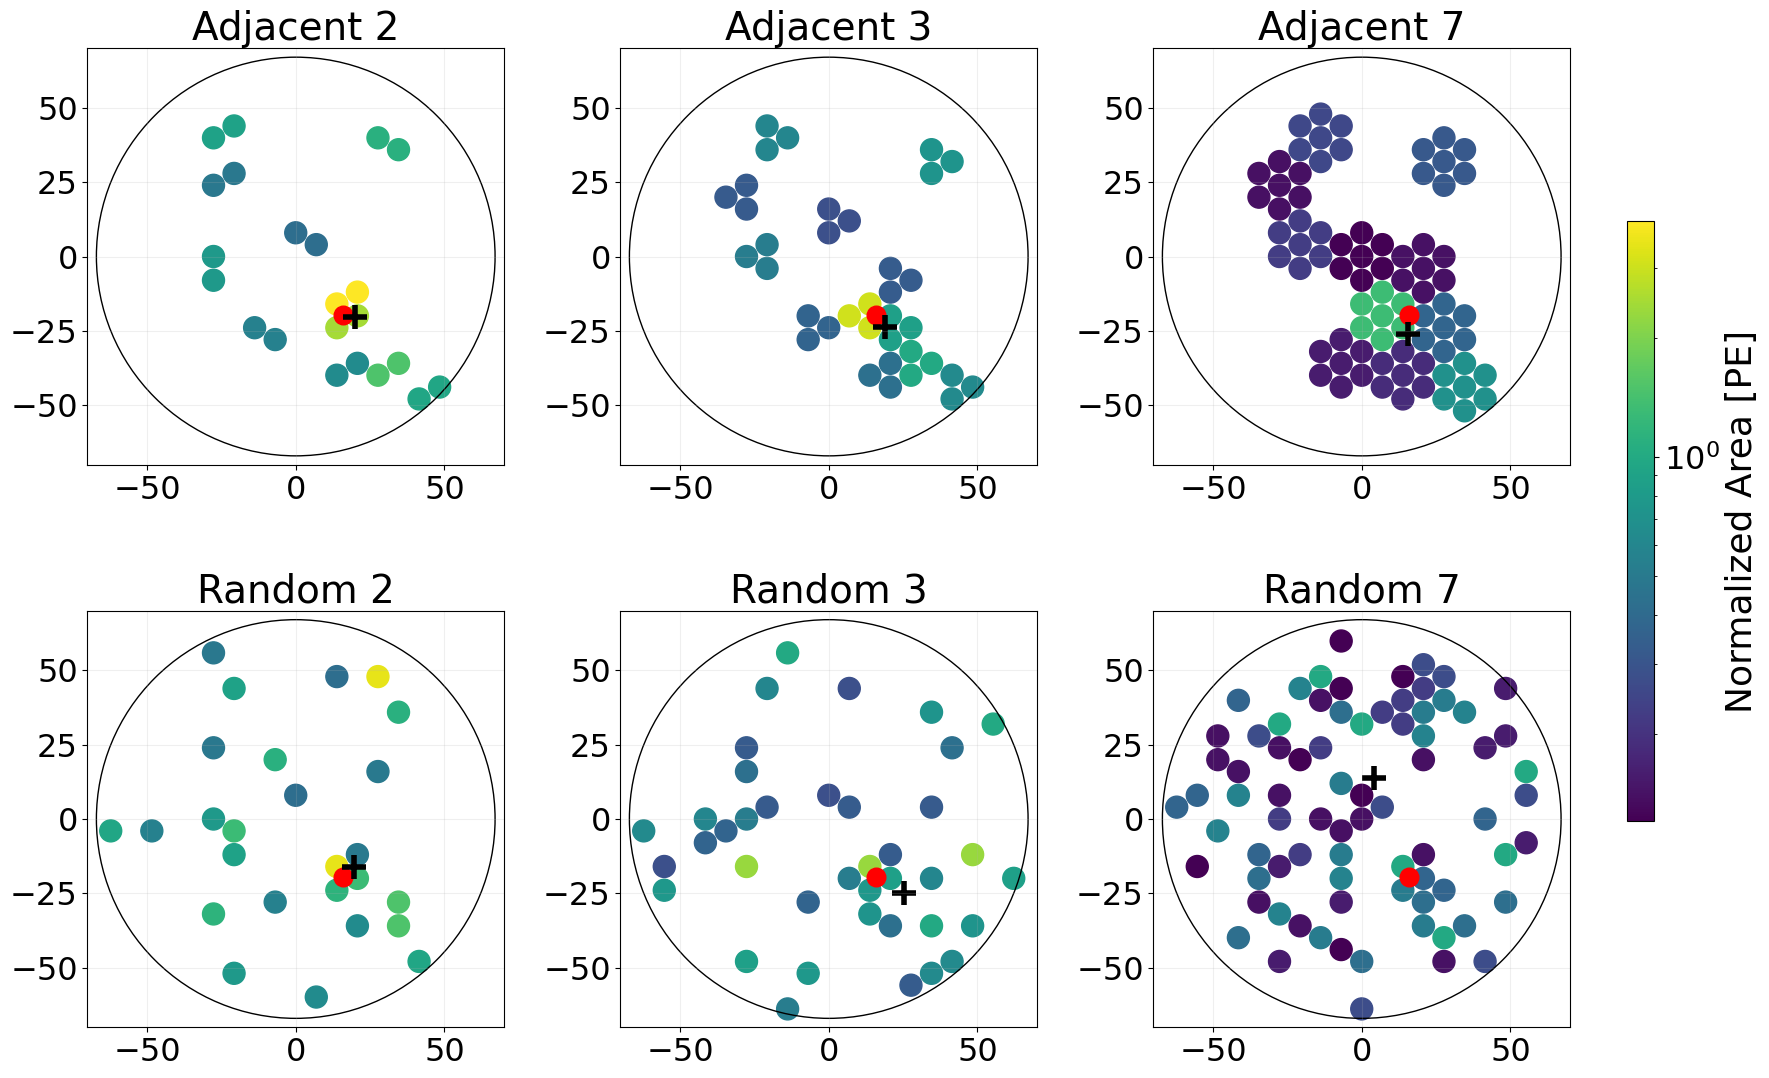

In [116]:
plot_hitpattern_grid(
    test_idx=130431,
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    base_npz_path="/scratch/midway3/nkoebelin/mux_data_new",
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=np.load("idx_test_global_area_cut.npy"),
    lookup_dict=np.load("global_index_lookup.npy", allow_pickle=True).item(),
    save_image=True
)


Saved: /home/nkoebelin/Images/ungrouped_event130431.png


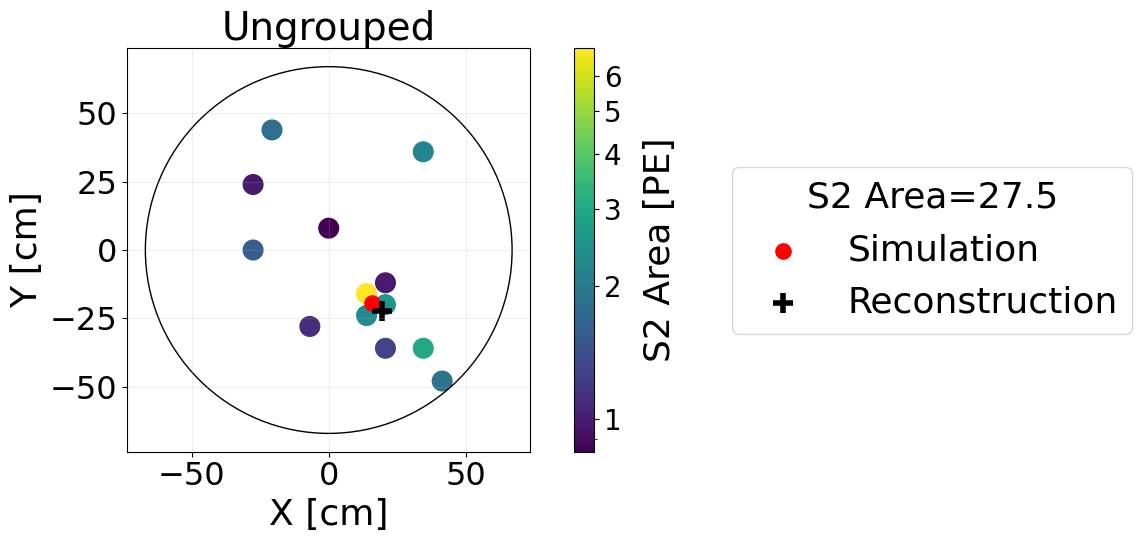

In [159]:
# Load required data
mux_name = "ungrouped"
idx_test_array = np.load("idx_test_global_area_cut.npy")
lookup_dict = np.load("global_index_lookup.npy", allow_pickle=True).item()
test_idx = 130431
global_idx = idx_test_array[test_idx]
filename, local_idx = lookup_dict[global_idx]

npz_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{mux_name}.npz"
npz = np.load(npz_path)

# Call the plotting function using global_idx for prediction arrays
plot_hitpattern_event(
    mux_name=mux_name,
    test_idx=test_idx,
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    npz_data_path=npz_path,
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=idx_test_array,
    lookup_dict=lookup_dict,
    #save_image=True
)

In [157]:
def plot_hitpattern_event(
    mux_name,
    test_idx,
    raw_data_path,
    npz_data_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images",
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os
    from matplotlib.ticker import ScalarFormatter

    os.makedirs(image_dir, exist_ok=True)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    # --- Font size setup to match reference layout ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })


    # --- Load geometry and grouping ---
    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
    groups = [np.array(g) for g in mux]

    # --- Load event data ---
    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    npz = np.load(npz_data_path)
    pred = npz["pos_pred"][test_idx]
    true = npz["pos_test"][test_idx]
    abs_err = npz["abs_errors"][test_idx]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(15, 6))
    sc = ax.scatter(pmt_x_top, pmt_y_top, c=hitpattern, cmap='viridis', marker='o',
                    s=200, norm=LogNorm())
    # Define ticks: only integer values within your expected range (adjust as needed)
    ticks = [1, 2, 3, 4, 5, 6]
    cbar = plt.colorbar(sc, ax=ax, ticks=ticks)
    cbar.set_label('S2 Area [PE]', labelpad=15)
    # Format ticks as plain integers
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
    cbar.ax.tick_params(labelsize=20)
    #cbar = plt.colorbar(sc, ax=ax, label='S2 Area [PE]')
    #cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('S2 Area [PE]', labelpad=15)  # Increase labelpad as needed (default is ~4)


    ax.scatter(interface_x, interface_y, c='red', marker='o', s=120, label='Simulation')
    ax.scatter(pred[0], pred[1], c='k', marker='+', linewidths=4, s=200,  label=f'Reconstruction')

    circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
    ax.add_patch(circle)

    ax.set_title("Ungrouped")
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")
    ax.set_aspect('equal')
    ax.grid(alpha=0.2)

    # --- Legend outside the plot ---
    ax.legend(
        title=f"S2 Area={s2_area:.1f}",
        loc="center left",
        bbox_to_anchor=(1.5, 0.5),
        borderaxespad=0,
        frameon=True
    )

    # Leave room on right for legend
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # --- Save image ---
    if save_image:
        default_name = f"{mux_name}_event{test_idx}.png"
        save_path = os.path.join(image_dir, default_name)
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()


In [82]:
import numpy as np

# Set your mux pattern name
mux_name = "rand_07_69"
data_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{mux_name}.npz"

# Load data
data = np.load(data_path)
abs_errors = data["abs_errors"]

# Find index of max error
#max_idx = np.argmax(abs_errors)
max_idx = np.argsort(abs_errors)[-5500]
max_error = abs_errors[max_idx]

print(f"Max reconstruction error for pattern '{mux_name}': {max_error:.2f} cm at event index {max_idx}")
print(len(abs_errors))

Max reconstruction error for pattern 'rand_07_69': 35.29 cm at event index 130431
377340


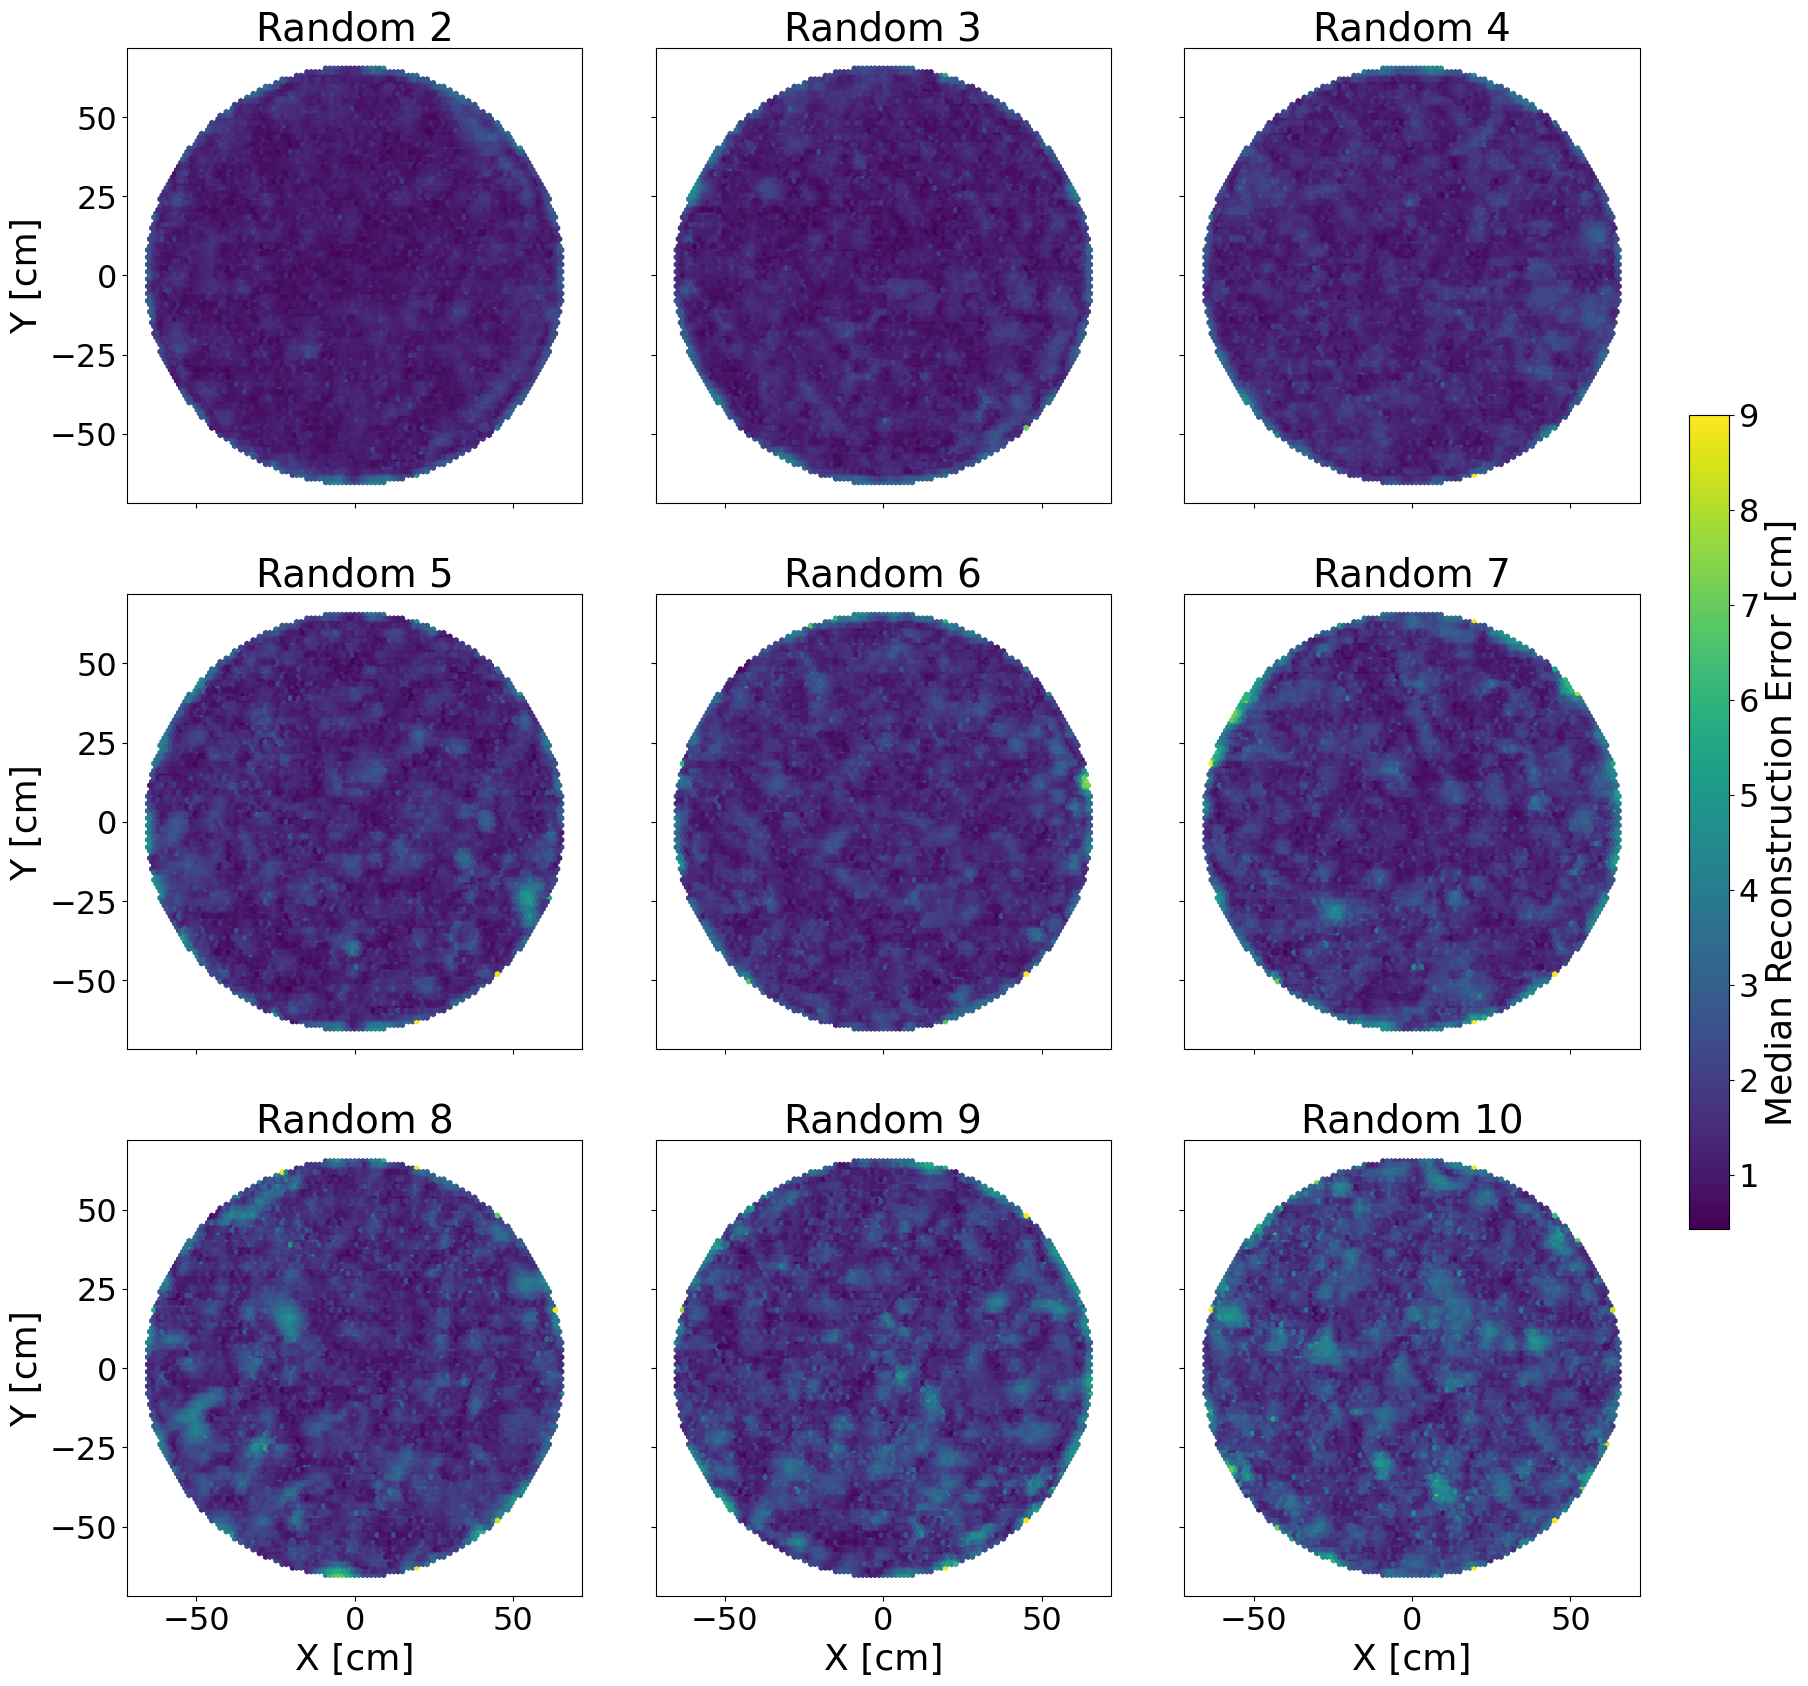

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Configuration ---
patterns = [
    'rand_02_82', 'rand_03_47', 'rand_04_91',
    'rand_05_76', 'rand_06_28', 'rand_07_69',
    'rand_08_64', 'rand_09_34', 'rand_10_94'
]

# Use this if you want the titles to match group size
titles = [
    "Random 2", "Random 3", "Random 4",
    "Random 5", "Random 6", "Random 7",
    "Random 8", "Random 9", "Random 10"
]

gridsize = 100
vmax = 9  # Adjust depending on your data range

# --- Create figure and axes ---
fig, axes = plt.subplots(3, 3, figsize=(21, 18), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.08, top=0.94)

# --- Loop through each model and plot hexbin ---
for idx, (ax, pattern_name, title) in enumerate(zip(axes.flatten(), patterns, titles)):
    data_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{pattern_name}.npz"
    data = np.load(data_path)
    x = data["pos_test"][:, 0]
    y = data["pos_test"][:, 1]
    values = data["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(title)
    #ax.set_xlabel("X [cm]")
    if idx % 3 == 0:  # First column
        ax.set_ylabel("Y [cm]")
    if idx // 3 == 2:  # First column
        ax.set_xlabel("X [cm]")

    ax.set_aspect("equal")
    #ax.grid(alpha=0.3)

# --- Shared colorbar ---
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.03)
cbar.set_label("Median Reconstruction Error [cm]")

# --- Optional global title ---
#fig.suptitle("Hexbin Maps of Median Reconstruction Error – Random Groupings", fontsize=20)

# --- Save or show ---
#plt.savefig("hexbin_median_error_random_3x3.png", dpi=300)
plt.show()
